In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [812]:
#sqlite 設定
con = sqlite3.connect('../../data/race_data_set.db') # データベースに接続する
con.enable_load_extension(True)
con.load_extension("../../../../sqlite-amalgamation-3260000/libsqlitefunctions.so")
cur = con.cursor()

sql_result = "select * from race_result"
sql_info   = "select * from race_info"
sql_pay = "select * from race_pay"

df_r2 = pd.read_sql_query(sql=sql_result,con=con)
df_i = pd.read_sql_query(sql=sql_info,con=con)

In [19]:

#df_p = pd.read_sql_query(sql=sql_pay,con=con)


In [20]:
df_r.head()

,race_id,stdev(last3f),avg(last3f)
0,201601010103,0.901413,39.736364
1,201601010104,1.128152,39.345455
2,201601010106,0.782738,35.687500
3,201601010108,0.551211,34.537500
4,201601010109,1.336902,38.230769


In [9]:
df_i.head(3)

,race_id,race_num,race_name,race_date,race_rank1,race_rank2,distance,kind,condition,place,horse_count,lap_time,conner1,conner2,conner3,conner4
0,202003010602,2,3歳未勝利,2020-04-26,3歳,未勝利,1200,芝,良,福島,16,12.3-10.7-11.3-11.7-11.4-12.5,None,None,"5(10,14)(4,9)(2,7)-(3,13,15)(11,12)16(1,8)=6","5(10,9,14)(4,7)(2,3)-(12,13,15)-11,16,8-1 6"
1,202003010603,3,3歳未勝利,2020-04-26,3歳,未勝利,1700,ダ,良,福島,15,7.3-11.3-11.9-12.8-13.1-12.9-13.3-13.0-13.3,"(*2,5)9(4,12,15)14(3,11)-(6,7)(8,13)(1,10)","2,5(4,9)12(3,15)14,11(6,7)-8,13,1,10","2,9(4,5,12,7)(15,11,1)14(6,10)(3,8)=13","(2,9,*7)(4,1)12-5(15,6,11,10)8,3,14-13"
2,202003010605,5,3歳未勝利,2020-04-26,3歳,未勝利,1200,芝,良,福島,16,12.6-10.9-11.2-12.0-11.9-12.5,None,None,"1,11(4,5)(2,16)3(6,10)(7,12)(8,13)(9,15)-14","1(11,5)(2,16)4(3,6,10)(7,12)8,13,9,15-14"


In [156]:
df_p.head(2)

,race_id,indicator,horse_1,horse_2,horse_3,pay
0,202003010602,tan,3,None,None,1010
1,202003010602,fuku,3,None,None,250


In [146]:
#レースの配当金の平均
df_p_ren3 = df_p[df_p["indicator"]=="sanfuku"]
print("全体平均",np.mean(df_p_ren3.pay))
#各カテゴリごとの平均
df_p_ren3 = df_p_ren3.merge(df_i,on='race_id',how='inner')
#開催場毎の平均
pay_data = df_p_ren3.pivot_table(index=["place","kind","distance"],values='pay',aggfunc=[np.mean,np.median,np.std, len],fill_value=0).reset_index()
pay_data.columns = ["place","kind","distance","pay_mean","pay_mid","pay_std","race_count"]
pay_data_mean=pay_data.sort_values(by='pay_mean', ascending=False)

c =0
for i in pay_data_mean.values:
    if i[6] > 50:
        print("{} {}{}m  平均{} 分散{} レース数{}".format(i[0],str(i[1]),str(i[2]),str(i[3]),str(i[5]),str(i[6])))
        c+=1
    if c ==15:
        break
print("-"*100)
pay_data_mid=pay_data.sort_values(by='pay_mid', ascending=False)
c=0
for i in pay_data_mid.values:
    if i[6] > 50:
        print("{} {}{}m  中央値{} 分散{} レース数{}".format(i[0],str(i[1]),str(i[2]),str(i[4]),str(i[5]),str(i[6])))
        c+=1
    if c ==15:
        break
print("-"*100)
pay_data_std=pay_data.sort_values(by='pay_std', ascending=True)
c=0
for i in pay_data_std.values:
    if i[6] > 50:
        print("{} {}{}m  平均{}/中央値{} 分散{} レース数{}".format(i[0],str(i[1]),str(i[2]),str(i[3]),str(i[4]),str(i[5]),str(i[6])))
        c+=1
    if c ==15:
        break

全体平均 24509.04499781564
小倉 芝1200m  平均44140.97046413502 分散97286.73084998761 レース数237
中京 芝1200m  平均40855.13513513513 分散115574.90634220254 レース数74
東京 ダ2100m  平均40481.13924050633 分散181195.66341239575 レース数158
中京 ダ1800m  平均40473.14410480349 分散364875.24394092354 レース数229
新潟 芝1600m  平均38937.74193548387 分散171803.51032139006 レース数62
阪神 ダ1400m  平均35677.36654804271 分散115592.54239184975 レース数281
京都 ダ1400m  平均34491.25925925926 分散98896.18219468063 レース数270
中山 ダ1800m  平均33517.14022140222 分散125650.72043478572 レース数542
福島 芝1800m  平均33384.782608695656 分散76650.03952570984 レース数92
東京 ダ1300m  平均32449.59595959596 分散93796.83056652223 レース数99
京都 芝1200m  平均31215.670103092783 分散68618.08917702897 レース数97
阪神 ダ1200m  平均30811.626794258373 分散114506.89248752019 レース数209
京都 芝1400m  平均29988.51485148515 分散77628.6498064489 レース数101
小倉 ダ1700m  平均28823.463035019457 分散94096.86926949225 レース数257
京都 ダ1200m  平均28161.181102362203 分散58010.17920235724 レース数254
--------------------------------------------------------------------------------------

In [155]:
df_p_ren3["year"] = pd.to_datetime(df_p_ren3["race_date"],format='%Y-%m-%d').dt.year
pay_data = df_p_ren3.pivot_table(index=["year","place","kind","distance"],values='pay',aggfunc=[np.mean,np.median,np.std, len],fill_value=0).reset_index()
pay_data.columns = ["year","place","kind","distance","pay_mean","pay_mid","pay_std","race_count"]
pay_data_mean=pay_data.sort_values(by='pay_mean', ascending=False)

c =0
for i in pay_data_mean.values:
    if i[7] > 50:
        print("{}:{} {}{}m  平均{}/中央値{} 分散{} レース数{}".format(str(i[0]),i[1],str(i[2]),str(i[3]),str(i[4]),str(i[5]),str(i[6]),str(i[7])))
        c+=1
    if c ==15:
        break
print("-"*100)
pay_data_mid=pay_data.sort_values(by='pay_mid', ascending=False)
c=0
for i in pay_data_mid.values:
    if i[7] > 50:
        print("{}:{} {}{}m  平均{}/中央値{} 分散{} レース数{}".format(str(i[0]),i[1],str(i[2]),str(i[3]),str(i[4]),str(i[5]),str(i[6]),str(i[7])))
        c+=1
    if c ==15:
        break
print("-"*100)
pay_data_std=pay_data.sort_values(by='pay_std', ascending=True)
c=0
for i in pay_data_std.values:
    if i[7] > 50:
        print("{}:{} {}{}m  平均{}/中央値{} 分散{} レース数{}".format(str(i[0]),i[1],str(i[2]),str(i[3]),str(i[4]),str(i[5]),str(i[6]),str(i[7])))
        c+=1
    if c ==15:
        break

2017:中京 ダ1800m  平均117570.55555555556/中央値5475 分散748184.7383851904 レース数54
2019:阪神 ダ1400m  平均65167.666666666664/中央値6720 分散186128.3085816884 レース数60
2017:中山 ダ1800m  平均59755.267857142855/中央値6905 分散234300.61285389622 レース数112
2017:京都 ダ1400m  平均58440.16949152543/中央値8560 分散171478.36516288665 レース数59
2017:小倉 ダ1700m  平均45210.181818181816/中央値5640 分散158078.67868144024 レース数55
2017:京都 ダ1800m  平均38966.52631578947/中央値6600 分散116324.33991626203 レース数95
2018:新潟 ダ1800m  平均38108.813559322036/中央値7440 分散81854.25477292038 レース数59
2019:阪神 ダ1800m  平均37864.395604395606/中央値3870 分散167164.05591320424 レース数91
2016:京都 ダ1400m  平均37286.031746031746/中央値6280 分散84625.59661084173 レース数63
2018:中山 ダ1800m  平均36815.625/中央値6550 分散98197.69885729052 レース数112
2018:京都 ダ1200m  平均35225.27272727273/中央値8360 分散80032.23433588877 レース数55
2017:中山 ダ1200m  平均30493.43137254902/中央値7820 分散71992.05208463383 レース数102
2019:小倉 ダ1700m  平均30439.444444444445/中央値6270 分散95566.07936972531 レース数54
2017:新潟 ダ1200m  平均29339.056603773584/中央値9610 分散58381.7825334684 レース数5

In [432]:
'''
荒れそうなレースは、短距離レース
'''

'\n荒れそうなレースは、短距離レース\n'

In [ ]:
def predict_race_dital_get(data):
    #race_idを抽出
    race_id_set = data.race_id.unique()
    race_info_set = {}
    cate_place = {0:'東京',1:'中山',2:'阪神',3:'京都',4:'小倉',5:'新潟',6:'福島',7:'中京',8:'札幌',9:'函館'}
    #race_idごとに馬情報をまとめる
    for race_id in race_id_set:
        horse = {}
        horse_set = data[data["race_id"]==race_id][["umaban","horse_id","horse_name"]]
        for horse_data in horse_set.drop_duplicates(subset=["umaban","horse_id","horse_name"]).values:
            horse[horse_data[0]] = [horse_data[1],horse_data[2]]
        race_set  = data[data["race_id"]==race_id][["race_num","race_name","place"]]
        race_set = race_set.drop_duplicates(subset=["race_num","race_name","place"]).values
        
        race_num = race_set[0][0]
        race_name = race_set[0][1]
        place = cate_place.get(race_set[0][2])
        race = {"race_num":race_num,"race_name":race_name,"place":place}
        race_info_set[race_id] = {"race":race,"horse":horse}
    return race_info_set

In [855]:
df = pd.read_csv("../../data/horse_data_set.csv")
df["pred_race_date"] = pd.to_datetime(df["pred_race_date"],format='%Y-%m-%d')
df["past_race_date"] = pd.to_datetime(df["past_race_date"],format='%Y-%m-%d')

In [811]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012624 entries, 0 to 1012623
Data columns (total 41 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   pred_race_id           1012624 non-null  int64         
 1   past_race_id           1012624 non-null  int64         
 2   horse_id               1012624 non-null  int64         
 3   horse_name             1012624 non-null  object        
 4   past_race_num          1012624 non-null  float64       
 5   pred_tyaku             1012624 non-null  int64         
 6   pred_wakuban           1012624 non-null  int64         
 7   pred_umaban            1012624 non-null  int64         
 8   pred_horse_years       1012624 non-null  int64         
 9   pred_horse_sex         1012624 non-null  object        
 10  pred_race_date         1012624 non-null  datetime64[ns]
 11  pred_race_rank1        1012624 non-null  object        
 12  pred_race_rank2        10126

In [840]:
df.groupby(["pred_distance","pred_kind"]).count()

pred_race_id  past_race_id  horse_id  horse_name  \
pred_distance pred_kind                                                     
1200          0                113592        113592    113592      113592   
              1                108359        108359    108359      108359   
1300          1                  7935          7935      7935        7935   
1400          0                 51561         51561     51561       51561   
              1                 95069         95069     95069       95069   
1500          0                  3164          3164      3164        3164   
1600          0                 71967         71967     71967       71967   
              1                 33647         33647     33647       33647   
1700          0                   348           348       348         348   
              1                 74414         74414     74414       74414   
1800          0                 79102         79102     79102       79102   
              1                150437        150437    150437      150437   
1900          1                 18426         18426     18426       18426   
2000          0                 95340         95340     95340       95340   
              1                  9181          9181      9181        9181   
2100          1                 16660         16660     16660       16660   
2200          0                 23751         23751     23751       23751   
2300          0                   258           258       258         258   
2400          0                 24181         24181     24181       24181   
              1                  9209          9209      9209        9209   
2500          0                  7101          7101      7101        7101   
              1                  1571          1571      1571        1571   
2600          0                 17351         17351     17351       17351   

                         past_race_num  pred_tyaku  pred_wakuban  pred_umaban  \
pred_distance pred_kind                                                         
1200          0                 113592      113592        113592       113592   
              1                 108359      108359        108359       108359   
1300          1                   7935        7935          7935         7935   
1400          0                  51561       51561         51561        51561   
              1                  95069       95069         95069        95069   
1500          0                   3164        3164          3164         3164   
1600          0                  71967       71967         71967        71967   
              1                  33647       33647         33647        33647   
1700          0                    348         348           348          348   
              1                  74414       74414         74414        74414   
1800          0                  79102       79102         79102        79102   
              1                 150437      150437        150437       150437   
1900          1                  18426       18426         18426        18426   
2000          0                  95340       95340         95340        95340   
              1                   9181        9181          9181         9181   
2100          1                  16660       16660         16660        16660   
2200          0                  23751       23751         23751        23751   
2300          0                    258         258           258          258   
2400          0                  24181       24181         24181        24181   
              1                   9209        9209          9209         9209   
2500          0                   7101        7101          7101         7101   
              1                   1571        1571          1571         1571   
2600          0                  17351       17351         17351        17351   

                         pred_horse_years  pred_horse_sex  ...  \
pred_di

In [350]:
red = df[df["horse_name"]=="レッドアステル"].groupby("pred_race_id").count().reset_index()

In [352]:
red.merge(df_i,how='inner',left_on="pred_race_id",right_on='race_id' )[["race_id","past_race_id","race_date","race_name"]].sort_values(by="race_date")


,race_id,past_race_id,race_date,race_name
2,201909020611,1,2019-04-07,第79回桜花賞(G1)
0,201901020309,2,2019-08-24,ルスツ特別
1,201905040310,3,2019-10-15,山中湖特別
3,202006030310,4,2020-04-04,湾岸ステークス


Index(['pred_race_id', 'past_race_id', 'horse_id', 'horse_name',
       'past_race_num', 'pred_tyaku', 'pred_wakuban', 'pred_umaban',
       'pred_horse_years', 'pred_horse_sex', 'pred_race_date',
       'pred_race_rank1', 'pred_race_rank2', 'pred_kind', 'pred_distance',
       'pred_condition', 'pred_place', 'pred_horse_weight',
       'pred_dif_horse_weight', 'past_tyaku', 'past_wakuban', 'past_umaban',
       'past_horse_sex', 'past_horse_years', 'past_kinryo', 'past_time',
       'past_last3f', 'past_p1', 'past_p2', 'past_p3', 'past_p4',
       'past_horse_weight', 'past_dif_horse_weight', 'past_race_date',
       'past_race_rank1', 'past_race_rank2', 'past_distance', 'past_kind',
       'past_condition', 'past_place', 'past_horse_count', 'past_lap_time',
       'past_dif_time', 'race_id', 'stdev(last3f)', 'avg(last3f)'],
      dtype='object')

In [765]:
#sqlite 設定
con = sqlite3.connect('../../data/race_data_set.db') # データベースに接続する
con.enable_load_extension(True)
con.load_extension("../../../../sqlite-amalgamation-3260000/libsqlitefunctions.so")
cur = con.cursor()

sql_result = "select race_id,stdev(last3f) as std3f,avg(last3f) as ave3f from race_result group by race_id"
sql_info   = "select * from race_info"
sql_pay = "select * from race_pay"

df_r = pd.read_sql_query(sql=sql_result,con=con)
df_i = pd.read_sql_query(sql=sql_info,con=con)

In [786]:
df = pd.read_csv("../../data/horse_data_set.csv")
df["pred_race_date"] = pd.to_datetime(df["pred_race_date"],format='%Y-%m-%d')
df["past_race_date"] = pd.to_datetime(df["past_race_date"],format='%Y-%m-%d')
df = df.merge(df_r,right_on="race_id",left_on="past_race_id",how="left")

In [787]:
#元データのコピー
df_c = df.copy()

In [788]:
df_c[["past_tyaku","past_dif_time1","past_dif_time2"]]

,past_tyaku,past_dif_time1,past_dif_time2
0,7,0.2,0.1
1,15,2.7,NaN
2,7,0.0,0.1
3,6,0.3,0.2
4,5,0.0,0.0
...,...,...,...
1012619,7,0.1,0.0
1012620,8,0.0,0.1
1012621,3,0.2,0.0
1012622,5,0.3,0.2


In [789]:
#last3f偏差値計算
df["h_last3f"] = (((df["past_last3f"]-df["ave3f"])*10)/df["std3f"])*-1+50
del_col = ['race_id','ave3f', 'std3f']
df = df.drop(columns=del_col)

In [790]:
#性別のカテゴライズ
cate_sex  = {'牝':0,'牡':1,'セ':2}
df['pred_horse_sex'] = df['pred_horse_sex'].apply(lambda x : cate_sex.get(x))
df['past_horse_sex'] = df['past_horse_sex'].apply(lambda x : cate_sex.get(x))

In [791]:
#競馬場のカテゴライズ
cate_place = {'東京':0,'中山':1,'阪神':2,'京都':3,'小倉':4,'新潟':5,'福島':6,'中京':7,'札幌':8,'函館':9}
df['pred_place'] = df['pred_place'].apply(lambda x : cate_place.get(x))
df['past_place'] = df['past_place'].apply(lambda x : cate_place.get(x))

In [792]:
#馬場状態のカテゴライズ
cate_condition ={'良':0,'稍重':1,'稍':1,'重':2,'不良':3,'不':3}
df['pred_condition'] = df['pred_condition'].apply(lambda x : cate_condition.get(x))
df['past_condition'] = df['past_condition'].apply(lambda x : cate_condition.get(x))

In [793]:
#レースランク1のカテゴライズ
cate_rank1 = {'2歳':0,'3歳':1,'3歳以上':2,'4歳以上':3}
df['pred_race_rank1'] = df['pred_race_rank1'].apply(lambda x : cate_rank1.get(x))
df['past_race_rank1'] = df['past_race_rank1'].apply(lambda x : cate_rank1.get(x))

In [794]:
#レースランク2のカテゴライズ
cate_rank2   = {'新馬':0,'未勝利':1,'500万下':2,'1000万下':3,'1600万下':4,'オープン':5,'1勝クラス':2,'2勝クラス':3,'3勝クラス':4,}
df['past_race_rank2'] = df['past_race_rank2'].apply(lambda x : cate_rank2.get(x))
df['pred_race_rank2'] = df['pred_race_rank2'].apply(lambda x : cate_rank2.get(x))

In [795]:
#コースの種類のカテゴライズ
cate_kind = {'芝':0,'ダ':1}
df['pred_kind'] = df['pred_kind'].apply(lambda x : cate_kind.get(x))
df['past_kind'] = df['past_kind'].apply(lambda x : cate_kind.get(x))

In [796]:
#最初のコーナー順位を取り出す
def first_past(data):
    past = 0
    for i in data:
        if i !=0:
            past=i
            break
    return past
df["first_past"] = df[["past_p1","past_p2","past_p3","past_p4"]].apply(lambda x: first_past(x),axis=1)

In [797]:
#位置取りの計算
df['dif_past'] = df["past_tyaku"] / df["past_p4"]

df["first_past"] = df["first_past"] / df["past_horse_count"]
df['past_p1'] = df["past_p1"] / df["past_horse_count"]
df['past_p2'] = df["past_p2"] / df["past_horse_count"]
df['past_p3'] = df["past_p3"] / df["past_horse_count"]
df['past_p4'] = df["past_p4"] / df["past_horse_count"]
df['past_pg'] = df["past_tyaku"] / df["past_horse_count"]
df['dif_past2'] = df["past_p3"] - df["past_p4"]

In [798]:
#ローテーションの計算
df['lotation'] = (df["pred_race_date"] - df["past_race_date"]).dt.days

In [799]:
#ラップタイムの変換
df["lapf1"] = None
df["lapf2"] = None
df["lapf3"] = None
df["lapf4"] = None
df["lapl3"] = None
df["lapl2"] = None
df["lapl1"] = None
df["dif_lap21"] = None
df["dif_lap32"] = None
df["dif_lap43"] = None
df["race_dif_3f"] = None
df["race_first_3f"] = None
df["race_last_3f"] = None
df[["lapf1","lapf2","lapf3","lapl3","lapf4","lapl2","lapl1"]] = [np.array(x.split('-'),dtype='float64')[[0,1,2,3,-3,-2,-1]] for x in df.past_lap_time]
df["lapf1"] = [x[0]/200.0 if (x[1]/100)%2 == 0 else x[0]/100.0 for x in df[["lapf1","past_distance"]].values]
df[["lapf2","lapf3","lapf4","lapl3","lapl2","lapl1"]] = df[["lapf2","lapf3","lapf4","lapl3","lapl2","lapl1"]]/200.0
df["race_first_3f"] = df["lapf1"]+ df["lapf2"] + df["lapf3"]
df["race_last_3f"]  = df["lapl1"]+ df["lapl2"] + df["lapl3"]
df["dif_lap21"] = df["lapf2"] - df["lapf1"]
df["dif_lap32"] = df["lapf3"] - df["lapf2"]
df["dif_lap43"] = df["lapf4"] - df["lapf3"]
df["race_dif_3f"] = df["race_first_3f"]-df["race_last_3f"]
df = df.drop(columns=["lapf4"])

In [800]:
#距離延長、短縮
df["dif_distance"] = (df["pred_distance"] - df["past_distance"])/200

In [801]:
#time-last3f
df["time_2"] = df["past_time"]-df["past_last3f"]

In [802]:
#距離分類
def distance_category(x):
    if x <= 1200:
        cate = 0
    elif x <= 1400:
        cate = 1
    elif x <= 1600:
        cate = 2
    elif x <= 1800:
        cate = 3
    elif x <= 2000:
        cate = 4
    elif x <= 2200:
        cate = 5
    elif x<=2400:
        cate = 6
    else:
        cate = 7
    return cate

df["pred_distance"] = df["pred_distance"].apply(lambda x : distance_category(x))
df["past_distance"] = df["past_distance"].apply(lambda x : distance_category(x))

In [803]:
df_past1 = df[(df["past_race_num"]==1)]
df_past2 = df[(df["past_race_num"]==2)]

#いらないカラムの削除
del_col = ['past_horse_weight','pred_horse_weight','past_race_id','horse_name','past_race_num','pred_wakuban','pred_race_date','past_tyaku','past_wakuban','past_race_date', 'past_horse_count', 'past_lap_time']
df_past1 = df_past1.drop(columns=del_col)
df_past2 = df_past2.drop(columns=del_col)
df_past = df_past1.merge(df_past2,on=merge_col,how='left')
#target 設定
df_past["target"] = df_past.pred_tyaku.apply(lambda x : 1 if x < 4 else 0)
df_past1["target"] = df_past1.pred_tyaku.apply(lambda x : 1 if x < 4 else 0)
df_past2["target"] = df_past2.pred_tyaku.apply(lambda x : 1 if x < 4 else 0)



In [721]:
#train test 作成
df_past = df_past.sample(frac=1)
df_past = df_past.dropna(how='any')
df_past.to_csv("train_all.csv",index=False)
train, test = train_test_split(df_past,train_size=0.9)
#train,test csv保存
train.to_csv("train.csv",index=False)
test.to_csv("test.csv",index=False)
#train data
x_train = train.iloc[:,3:-1]
x_label = train.target.values
x_columns=x_train.columns
x_train = x_train.values

In [804]:
#禅僧
df_past1 = df_past1.sample(frac=1)
train, test = train_test_split(df_past1,train_size=0.8,stratify=y,random_state=1)
#train data
x_train = train.iloc[:,3:-1]
x_label = train.target.values
x_columns=x_train.columns
x_train = x_train.values

In [631]:
#自走
df_past2 = df_past2.sample(frac=1)
train, test = train_test_split(df_past2,train_size=0.8)
#train data
x_train = train.iloc[:,3:-1]
x_label = train.target.values
x_columns=x_train.columns
x_train = x_train.values

In [689]:
#階層クラスタリング
import fastcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Z = fastcluster.linkage_vector(x_train,method='ward',metric='euclidean')
Z_dataframe = pd.DataFrame(data=Z,columns = ['clus1','clus2','dis','newculssize'])

KeyboardInterrupt: 

In [811]:
df_past1[["pred_race_id","horse_id","pred_umaban","race_first_3f","first_past","past_p4"]]#.groupby("pred_race_id").apply(lambda x : x.sort_values(by='pred_umaban'))

,pred_race_id,horse_id,pred_umaban,race_first_3f,first_past,past_p4
89428,201609030410,2013102855,14,0.1740,0.200000,0.200000
792439,201907030812,2015100608,14,0.1930,0.272727,0.272727
46299,201605050607,2013109028,6,0.1700,0.500000,0.375000
85775,201609020210,2012101421,4,0.1695,0.125000,0.125000
499786,201807030304,2015102080,4,0.1880,0.071429,0.214286
...,...,...,...,...,...,...
381235,201804010606,2015100874,12,0.1840,0.500000,0.687500
427708,201805030704,2015102658,5,0.1820,0.687500,0.500000
104966,201610020912,2013102480,3,0.1695,0.437500,0.500000
381963,201804010611,2012110063,8,0.1925,0.187500,0.187500


In [953]:
#距離種類ごとにtrain/testを作成
#いらないカラムの削除
del_col = ['past_horse_weight','pred_horse_weight','past_race_id','horse_name',"past_distance",'pred_wakuban','pred_race_date','past_tyaku','past_wakuban','past_race_date', 'past_horse_count', 'past_lap_time']
df = df.drop(columns=del_col)

In [639]:
df[df["past_race_num"]==3].groupby(["pred_distance","pred_kind","past_race_num"]).count()

pred_race_id  past_race_id  horse_id  \
pred_distance pred_kind past_race_num                                         
0             0         3.0                   10871         10871     10871   
              1         3.0                   11053         11053     11053   
1             0         3.0                    4911          4911      4911   
              1         3.0                   10319         10319     10319   
2             0         3.0                    7452          7452      7452   
              1         3.0                    3565          3565      3565   
3             0         3.0                    8083          8083      8083   
              1         3.0                   23060         23060     23060   
4             0         3.0                    9649          9649      9649   
              1         3.0                    2497          2497      2497   
5             0         3.0                    2345          2345      2345   
              1         3.0                    1596          1596      1596   
6             0         3.0                    2421          2421      2421   
              1         3.0                     856           856       856   
7             0         3.0                    2275          2275      2275   
              1         3.0                     145           145       145   

                                       horse_name  pred_tyaku  pred_wakuban  \
pred_distance pred_kind past_race_num                                         
0             0         3.0                 10871       10871         10871   
              1         3.0                 11053       11053         11053   
1             0         3.0                  4911        4911          4911   
              1         3.0                 10319       10319         10319   
2             0         3.0                  7452        7452          7452   
              1         3.0                  3565        3565          3565   
3             0         3.0                  8083        8083          8083   
              1         3.0                 23060       23060         23060   
4             0         3.0                  9649        9649          9649   
              1         3.0                  2497        2497          2497   
5             0         3.0                  2345        2345          2345   
              1         3.0                  1596        1596          1596   
6             0         3.0                  2421        2421          2421   
              1         3.0                   856         856           856   
7             0         3.0                  2275        2275          2275   
              1         3.0                   145         145           145   

                                       pred_umaban  pred_horse_years  \
pred_distance pred_kind past_race_num                                  
0             0         3.0                  10871             10871   
              1         3.0                  11053             11053   
1             0         3.0                   4911              4911   
              1         3.0                  10319             10319   
2             0         3.0                   7452              7452   
              1         3.0                   3565              3565   
3             0         3.0                   8083              8083   
              1         3.0                  23060             23060   
4             0         3.0                   9649              9649   
              1         3.0                   2497              2497   
5             0         3.0                   2345              2345   
              1         3.0                   1596              1596   
6             0         3.0                   2421              2421   
              1         3.0                    856               856   
7             0         3.0              

In [824]:
#最初のコーナー順位を取り出す
def first_past(data):
    past = 0
    for i in data:
        if i !=0:
            past=i
            break
    return past

sql_result = "select race_id as pred_race_id,horse_id,p1,p2,p3,p4 from race_result"
df_r2 = pd.read_sql_query(sql=sql_result,con=con)
df_r2["target"] = df_r2[["p1","p2","p3","p4"]].apply(lambda x: first_past(x),axis=1)
iti_data = df_past1[["pred_race_id","horse_id","pred_umaban","race_first_3f","first_past","past_p4"]]
iti_data = iti_data.merge(df_r2[["pred_race_id","horse_id","target"]],on=["pred_race_id","horse_id"],how='inner')

In [826]:
iti_data.to_csv("trainitit.csv",index=False)

In [15]:
def csv_make_group(group_data):
    del_col = ['past_horse_weight','pred_horse_weight','past_race_id','horse_name','past_race_num','pred_wakuban','pred_race_date','past_tyaku','past_wakuban','past_race_date', 'past_horse_count', 'past_lap_time']
    for name, group in group_data:
        file_name = "{}_{}_{}.csv".format(str(name[0]),str(name[1]),str(int(name[2])))
        if name[2] < 4:
            csv_data = group.drop(columns=del_col)
            csv_data["target"] = csv_data.pred_tyaku.apply(lambda x : 1 if x < 4 else 0)
            csv_data.to_csv("../../data/model_v2_diskind/{}".format(file_name),index=False)

csv_make_group(df.groupby(["pred_distance","pred_kind","past_race_num"]))

In [416]:
merge_col=['pred_race_id', 'horse_id',
       'pred_tyaku', 'pred_umaban',
       'pred_horse_years', 'pred_horse_sex',
       'pred_race_rank1', 'pred_race_rank2', 'pred_kind', 'pred_distance',
       'pred_condition', 'pred_place', 'pred_dif_horse_weight']

In [440]:
#前走
#df_past1 = df[(df["past_race_num"]==1) &(df["pred_tyaku"]<13)]
df_past1 = df[(df["past_race_num"]==1)]
df_past2 = df[(df["past_race_num"]==2)]

#いらないカラムの削除
del_col = ['past_horse_weight','pred_horse_weight','past_race_id','horse_name','past_race_num','pred_wakuban','pred_race_date','past_tyaku','past_wakuban','past_race_date', 'past_horse_count', 'past_lap_time']
df_past1 = df_past1.drop(columns=del_col)
df_past2 = df_past2.drop(columns=del_col)
df_past = df_past1.merge(df_past2,on=merge_col,how='left')
#target 設定
df_past["target"] = df_past.pred_tyaku.apply(lambda x : 1 if x < 4 else 0)


FloatingPointError: NaN dissimilarity value.

In [441]:
df_data = df_past.dropna(how='any')

In [186]:
df_1200_1 = pd.read_csv("../../data/model_v2_diskind/1200_0_1.csv")
df_1200_2 = pd.read_csv("../../data/model_v2_diskind/1200_1_1.csv")
df = pd.concat([df_1200_1,df_1200_2])


In [442]:
df_data.columns

Index(['pred_race_id', 'horse_id', 'pred_tyaku', 'pred_umaban',
       'pred_horse_years', 'pred_horse_sex', 'pred_race_rank1',
       'pred_race_rank2', 'pred_kind', 'pred_distance', 'pred_condition',
       'pred_place', 'pred_dif_horse_weight', 'past_umaban_x',
       'past_horse_sex_x', 'past_horse_years_x', 'past_kinryo_x',
       'past_time_x', 'past_last3f_x', 'past_p1_x', 'past_p2_x', 'past_p3_x',
       'past_p4_x', 'past_dif_horse_weight_x', 'past_race_rank1_x',
       'past_race_rank2_x', 'past_distance_x', 'past_kind_x',
       'past_condition_x', 'past_place_x', 'past_dif_time_x', 'h_last3f_x',
       'past_pg_x', 'df_past_x', 'lotation_x', 'lapf1_x', 'lapf2_x', 'lapf3_x',
       'lapl2_x', 'lapl1_x', 'dif_distance_x', 'past_umaban_y',
       'past_horse_sex_y', 'past_horse_years_y', 'past_kinryo_y',
       'past_time_y', 'past_last3f_y', 'past_p1_y', 'past_p2_y', 'past_p3_y',
       'past_p4_y', 'past_dif_horse_weight_y', 'past_race_rank1_y',
       'past_race_rank2_y', '

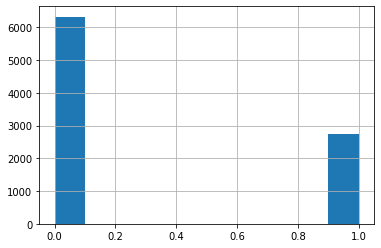

In [66]:
df_1200_10.target.hist()

In [135]:
#データのundersamplingとバギング
print(len(df_1200[df_1200.target==1]))

2751


In [397]:

#x_train, x_eval,y_label, eval_label = train_test_split(x_train,x_label,train_size=0.8)

In [752]:
#liightgbm 学習
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': 'binary_logloss',
          'learning_rate':0.01,
          'num_iterations':3000,
          'verbosity': -1,
          'early_stopping_rounds': 100,
          'max_depth':10,
            }

In [468]:
#交差検証の設定
from sklearn.model_selection import StratifiedKFold,KFold,train_test_split
num_kfold = 5
kf = KFold(n_splits=num_kfold,shuffle=True,random_state=1)

In [223]:
from imblearn.under_sampling import RandomUnderSampler
sampling_strategy = 0.7
sampler = RandomUnderSampler(random_state=42,sampling_strategy=sampling_strategy)
X_resampled, y_resampled = sampler.fit_resample(x_train, x_label)
#x_train, x_eval,y_label, eval_label = train_test_split(X_resampled,y_resampled,train_size=0.8)

In [764]:
print(len(x_train))
print(len(x_train[x_label==0]))
print(len(x_train[x_label==1]))

111836
87820
24016


In [748]:
def under_sample_bagging(train,label):
    #undersampling
    sampling_strategy = 0.7
    sampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
    X_resampled, y_resampled = sampler.fit_resample(train, label)
    f_label=len(X_resampled[y_resampled==0])
    t_label=len(X_resampled[y_resampled==1])
    #バギングする方のデータの長さを取得
    if f_label < t_label:
        choice_data = X_resampled[y_resampled==0]
        choice_label= y_resampled[y_resampled==0]
        idx = np.arange(0,f_label)
        bagging_data_num = t_label-f_label
        choice_idx = np.random.choice(idx, bagging_data_num, replace=True)
    else:
        choice_data = X_resampled[y_resampled==1]
        choice_label= y_resampled[y_resampled==1]
        idx = np.arange(0,t_label)
        bagging_data_num = f_label-t_label
        choice_idx = np.random.choice(idx, bagging_data_num, replace=True)
    #bagging
    X_resampled=np.append(X_resampled,choice_data[choice_idx],axis=0)
    y_resampled=np.append(y_resampled,choice_label[choice_idx],axis=0)
    #データをシャッフル
    p = np.random.permutation(len(X_resampled))
    return X_resampled[p],y_resampled[p]


In [805]:
model_set = []
for i,(train_index, test_index) in enumerate(kf.split(x_train, x_label)):
    #print(len(train_index))
    X_resampled,y_resampled=under_sample_bagging(x_train[train_index], x_label[train_index])
    train_data = lgb.Dataset(X_resampled, label=y_resampled)
    eval_data  = lgb.Dataset(x_train[test_index], label=x_label[test_index], reference= train_data)
    #モデルの学習
    model = lgb.train(params, 
                      train_data, 
                      valid_names=evals_name,
                      valid_sets=[eval_data,train_data],
                      evals_result=evals_result,
                      verbose_eval=False)
    model_set.append(model)

/home/h-kobayashi/anaconda3/envs/mypy/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/h-kobayashi/anaconda3/envs/mypy/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/h-kobayashi/anaconda3/envs/mypy/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/h-kobayashi/anaconda3/envs/mypy/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use i

In [225]:
print(len(X_resampled[y_resampled == 1, 0]))
print(len(X_resampled[y_resampled == 0, 0]))

5426
7751


In [196]:
evals_result={}
evals_name=["train_cv_1","eval_cv_1"]
train_data = lgb.Dataset(x_train, label=y_label)
eval_data  = lgb.Dataset(x_eval, label=eval_label, reference= train_data)
model      = lgb.train(params, train_data, valid_names=evals_name,valid_sets=[train_data,eval_data],evals_result=evals_result,verbose_eval=False)

/home/h-kobayashi/anaconda3/envs/mypy/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/h-kobayashi/anaconda3/envs/mypy/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [756]:
model_set = []
for i,(train_index, test_index) in enumerate(kf.split(x_train, x_label)):
    #lightgbmの学習遷移を格納する配列
    evals_result={}
    #学習遷移のdictのKey
    evals_name=["eval_cv{}".format(i),"train_cv{}".format(i)]
    #LightGBM用のデータに変換
    print(test_index)
    train_data = lgb.Dataset(x_train[train_index], label=x_label[train_index])
    eval_data  = lgb.Dataset(x_train[test_index], label=x_label[test_index], reference= train_data)
    #モデルの学習    学習モデルの保存MLflow
    model = lgb.train(params, 
                      train_data, 
                      valid_names=evals_name,
                      valid_sets=[eval_data,train_data],
                      evals_result=evals_result,
                      verbose_eval=False)
    model_set.append(model)

[     1      4      6 ... 111825 111826 111831]


/home/h-kobayashi/anaconda3/envs/mypy/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/h-kobayashi/anaconda3/envs/mypy/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[    17     20     23 ... 111811 111821 111829]
[     3     13     14 ... 111819 111822 111832]
[     0      2      5 ... 111818 111827 111833]
[     7      9     15 ... 111830 111834 111835]


In [180]:
evals_result={}
evals_name=["train_cv_1","eval_cv_1"]
train_data = lgb.Dataset(x_train, label=y_label)
eval_data  = lgb.Dataset(x_eval, label=eval_label, reference= train_data)
model      = lgb.train(params, train_data, valid_names=evals_name,valid_sets=[train_data,eval_data],evals_result=evals_result)

/home/h-kobayashi/anaconda3/envs/mypy/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/h-kobayashi/anaconda3/envs/mypy/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	train_cv_1's binary_logloss: 0.498454	eval_cv_1's binary_logloss: 0.485797
Training until validation scores don't improve for 1000 rounds
[2]	train_cv_1's binary_logloss: 0.497249	eval_cv_1's binary_logloss: 0.48489
[3]	train_cv_1's binary_logloss: 0.496094	eval_cv_1's binary_logloss: 0.484019
[4]	train_cv_1's binary_logloss: 0.49499	eval_cv_1's binary_logloss: 0.483209
[5]	train_cv_1's binary_logloss: 0.493925	eval_cv_1's binary_logloss: 0.482472
[6]	train_cv_1's binary_logloss: 0.492898	eval_cv_1's binary_logloss: 0.481747
[7]	train_cv_1's binary_logloss: 0.491916	eval_cv_1's binary_logloss: 0.481035
[8]	train_cv_1's binary_logloss: 0.490977	eval_cv_1's binary_logloss: 0.480367
[9]	train_cv_1's binary_logloss: 0.49005	eval_cv_1's binary_logloss: 0.479743
[10]	train_cv_1's binary_logloss: 0.489177	eval_cv_1's binary_logloss: 0.479127
[11]	train_cv_1's binary_logloss: 0.488324	eval_cv_1's binary_logloss: 0.478529
[12]	train_cv_1's binary_logloss: 0.487502	eval_cv_1's binary_logloss

[152]	train_cv_1's binary_logloss: 0.455968	eval_cv_1's binary_logloss: 0.477964
[153]	train_cv_1's binary_logloss: 0.455906	eval_cv_1's binary_logloss: 0.478064
[154]	train_cv_1's binary_logloss: 0.455814	eval_cv_1's binary_logloss: 0.478152
[155]	train_cv_1's binary_logloss: 0.455713	eval_cv_1's binary_logloss: 0.478202
[156]	train_cv_1's binary_logloss: 0.455616	eval_cv_1's binary_logloss: 0.478243
[157]	train_cv_1's binary_logloss: 0.45553	eval_cv_1's binary_logloss: 0.478319
[158]	train_cv_1's binary_logloss: 0.455446	eval_cv_1's binary_logloss: 0.478418
[159]	train_cv_1's binary_logloss: 0.455383	eval_cv_1's binary_logloss: 0.478505
[160]	train_cv_1's binary_logloss: 0.455296	eval_cv_1's binary_logloss: 0.47857
[161]	train_cv_1's binary_logloss: 0.455195	eval_cv_1's binary_logloss: 0.478657
[162]	train_cv_1's binary_logloss: 0.455112	eval_cv_1's binary_logloss: 0.478766
[163]	train_cv_1's binary_logloss: 0.455049	eval_cv_1's binary_logloss: 0.478827
[164]	train_cv_1's binary_logl

[367]	train_cv_1's binary_logloss: 0.43492	eval_cv_1's binary_logloss: 0.486705
[368]	train_cv_1's binary_logloss: 0.434757	eval_cv_1's binary_logloss: 0.486732
[369]	train_cv_1's binary_logloss: 0.43464	eval_cv_1's binary_logloss: 0.486725
[370]	train_cv_1's binary_logloss: 0.434551	eval_cv_1's binary_logloss: 0.4867
[371]	train_cv_1's binary_logloss: 0.434423	eval_cv_1's binary_logloss: 0.486715
[372]	train_cv_1's binary_logloss: 0.43427	eval_cv_1's binary_logloss: 0.486721
[373]	train_cv_1's binary_logloss: 0.434177	eval_cv_1's binary_logloss: 0.486742
[374]	train_cv_1's binary_logloss: 0.434011	eval_cv_1's binary_logloss: 0.486756
[375]	train_cv_1's binary_logloss: 0.433922	eval_cv_1's binary_logloss: 0.48673
[376]	train_cv_1's binary_logloss: 0.433815	eval_cv_1's binary_logloss: 0.486723
[377]	train_cv_1's binary_logloss: 0.433744	eval_cv_1's binary_logloss: 0.486717
[378]	train_cv_1's binary_logloss: 0.433614	eval_cv_1's binary_logloss: 0.486696
[379]	train_cv_1's binary_logloss:

[523]	train_cv_1's binary_logloss: 0.417722	eval_cv_1's binary_logloss: 0.486778
[524]	train_cv_1's binary_logloss: 0.417594	eval_cv_1's binary_logloss: 0.486767
[525]	train_cv_1's binary_logloss: 0.41753	eval_cv_1's binary_logloss: 0.486778
[526]	train_cv_1's binary_logloss: 0.417474	eval_cv_1's binary_logloss: 0.486797
[527]	train_cv_1's binary_logloss: 0.417337	eval_cv_1's binary_logloss: 0.486755
[528]	train_cv_1's binary_logloss: 0.417279	eval_cv_1's binary_logloss: 0.486788
[529]	train_cv_1's binary_logloss: 0.417213	eval_cv_1's binary_logloss: 0.486786
[530]	train_cv_1's binary_logloss: 0.417053	eval_cv_1's binary_logloss: 0.486766
[531]	train_cv_1's binary_logloss: 0.416923	eval_cv_1's binary_logloss: 0.486739
[532]	train_cv_1's binary_logloss: 0.416789	eval_cv_1's binary_logloss: 0.48674
[533]	train_cv_1's binary_logloss: 0.416677	eval_cv_1's binary_logloss: 0.486749
[534]	train_cv_1's binary_logloss: 0.416587	eval_cv_1's binary_logloss: 0.486772
[535]	train_cv_1's binary_logl

[681]	train_cv_1's binary_logloss: 0.399809	eval_cv_1's binary_logloss: 0.485723
[682]	train_cv_1's binary_logloss: 0.399682	eval_cv_1's binary_logloss: 0.485693
[683]	train_cv_1's binary_logloss: 0.399585	eval_cv_1's binary_logloss: 0.485669
[684]	train_cv_1's binary_logloss: 0.399478	eval_cv_1's binary_logloss: 0.485661
[685]	train_cv_1's binary_logloss: 0.399401	eval_cv_1's binary_logloss: 0.485668
[686]	train_cv_1's binary_logloss: 0.399276	eval_cv_1's binary_logloss: 0.485661
[687]	train_cv_1's binary_logloss: 0.399163	eval_cv_1's binary_logloss: 0.485632
[688]	train_cv_1's binary_logloss: 0.399056	eval_cv_1's binary_logloss: 0.485666
[689]	train_cv_1's binary_logloss: 0.398971	eval_cv_1's binary_logloss: 0.485656
[690]	train_cv_1's binary_logloss: 0.398919	eval_cv_1's binary_logloss: 0.485674
[691]	train_cv_1's binary_logloss: 0.398792	eval_cv_1's binary_logloss: 0.485679
[692]	train_cv_1's binary_logloss: 0.398674	eval_cv_1's binary_logloss: 0.485658
[693]	train_cv_1's binary_lo

[834]	train_cv_1's binary_logloss: 0.384157	eval_cv_1's binary_logloss: 0.485087
[835]	train_cv_1's binary_logloss: 0.38406	eval_cv_1's binary_logloss: 0.485102
[836]	train_cv_1's binary_logloss: 0.383943	eval_cv_1's binary_logloss: 0.485094
[837]	train_cv_1's binary_logloss: 0.383892	eval_cv_1's binary_logloss: 0.485098
[838]	train_cv_1's binary_logloss: 0.383809	eval_cv_1's binary_logloss: 0.48509
[839]	train_cv_1's binary_logloss: 0.383692	eval_cv_1's binary_logloss: 0.485086
[840]	train_cv_1's binary_logloss: 0.383569	eval_cv_1's binary_logloss: 0.485097
[841]	train_cv_1's binary_logloss: 0.383467	eval_cv_1's binary_logloss: 0.485054
[842]	train_cv_1's binary_logloss: 0.383348	eval_cv_1's binary_logloss: 0.485055
[843]	train_cv_1's binary_logloss: 0.383305	eval_cv_1's binary_logloss: 0.485074
[844]	train_cv_1's binary_logloss: 0.3832	eval_cv_1's binary_logloss: 0.485078
[845]	train_cv_1's binary_logloss: 0.383067	eval_cv_1's binary_logloss: 0.485065
[846]	train_cv_1's binary_loglos

[945]	train_cv_1's binary_logloss: 0.372818	eval_cv_1's binary_logloss: 0.4846
[946]	train_cv_1's binary_logloss: 0.372709	eval_cv_1's binary_logloss: 0.484578
[947]	train_cv_1's binary_logloss: 0.372668	eval_cv_1's binary_logloss: 0.484593
[948]	train_cv_1's binary_logloss: 0.372637	eval_cv_1's binary_logloss: 0.484599
[949]	train_cv_1's binary_logloss: 0.372543	eval_cv_1's binary_logloss: 0.484601
[950]	train_cv_1's binary_logloss: 0.372435	eval_cv_1's binary_logloss: 0.48461
[951]	train_cv_1's binary_logloss: 0.372317	eval_cv_1's binary_logloss: 0.484612
[952]	train_cv_1's binary_logloss: 0.372197	eval_cv_1's binary_logloss: 0.484613
[953]	train_cv_1's binary_logloss: 0.372172	eval_cv_1's binary_logloss: 0.484624
[954]	train_cv_1's binary_logloss: 0.372044	eval_cv_1's binary_logloss: 0.484574
[955]	train_cv_1's binary_logloss: 0.371914	eval_cv_1's binary_logloss: 0.484594
[956]	train_cv_1's binary_logloss: 0.371823	eval_cv_1's binary_logloss: 0.484601
[957]	train_cv_1's binary_loglo

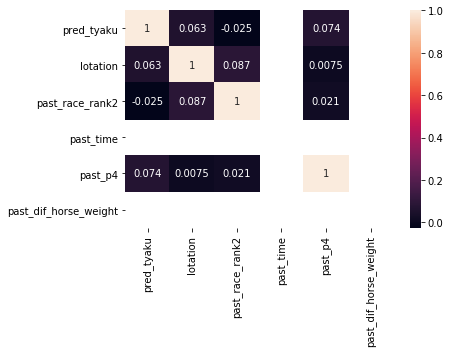

In [318]:
#heat_mapを確認
cols = ['pred_tyaku', 'lotation', 'past_race_rank2', 'past_time', 'past_p4','past_dif_horse_weight']
cm = np.corrcoef(df_past1[cols].values.T)
sns.heatmap(cm,cbar=True,annot=True,yticklabels=cols,xticklabels=cols)

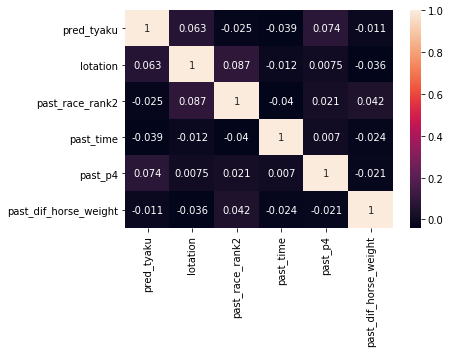

In [319]:
cm = df_past1[cols].corr().values
sns.heatmap(cm,cbar=True,annot=True,yticklabels=cols,xticklabels=cols)

In [905]:
df_past1.columns

Index(['pred_race_id', 'horse_id', 'pred_tyaku', 'pred_umaban',
       'pred_horse_years', 'pred_horse_sex', 'pred_race_rank1',
       'pred_race_rank2', 'pred_kind', 'pred_distance', 'pred_condition',
       'pred_place', 'pred_horse_weight', 'pred_dif_horse_weight',
       'past_umaban', 'past_horse_sex', 'past_horse_years', 'past_kinryo',
       'past_time', 'past_last3f', 'past_p1', 'past_p2', 'past_p3', 'past_p4',
       'past_horse_weight', 'past_dif_horse_weight', 'past_race_rank1',
       'past_race_rank2', 'past_distance', 'past_kind', 'past_condition',
       'past_place', 'past_dif_time', 'past_pg', 'lotation', 'lapf1', 'lapf2',
       'lapf3', 'lapl2', 'lapl1', 'dif_distance', 'target'],
      dtype='object')

In [906]:
#レース開場ごとの開催数
df_past1.groupby("pred_place").count()["pred_race_id"]

pred_place
0    18095
1    16428
2    17732
3    16893
4     8486
5     9528
6     7413
7    10976
8     4440
9     4699
Name: pred_race_id, dtype: int64

In [907]:
#距離をカテゴライズ
#df_past1["pred_distance"].unique()
df_past1["pred_distance"] = df_past1.pred_distance.apply(lambda x: int(x/200))
df_past1["past_distance"] = df_past1.past_distance.apply(lambda x: int(x/200))

In [476]:
x_columns

Index(['pred_umaban', 'pred_horse_years', 'pred_horse_sex', 'pred_race_rank1',
       'pred_race_rank2', 'pred_kind', 'pred_distance', 'pred_condition',
       'pred_place', 'pred_dif_horse_weight', 'past_umaban_x',
       'past_horse_sex_x', 'past_horse_years_x', 'past_kinryo_x',
       'past_time_x', 'past_last3f_x', 'past_p1_x', 'past_p2_x', 'past_p3_x',
       'past_p4_x', 'past_dif_horse_weight_x', 'past_race_rank1_x',
       'past_race_rank2_x', 'past_distance_x', 'past_kind_x',
       'past_condition_x', 'past_place_x', 'past_dif_time_x', 'h_last3f_x',
       'past_pg_x', 'df_past_x', 'lotation_x', 'lapf1_x', 'lapf2_x', 'lapf3_x',
       'lapl2_x', 'lapl1_x', 'dif_distance_x', 'past_umaban_y',
       'past_horse_sex_y', 'past_horse_years_y', 'past_kinryo_y',
       'past_time_y', 'past_last3f_y', 'past_p1_y', 'past_p2_y', 'past_p3_y',
       'past_p4_y', 'past_dif_horse_weight_y', 'past_race_rank1_y',
       'past_race_rank2_y', 'past_distance_y', 'past_kind_y',
       'past_con

In [540]:
x_columns

Index(['pred_umaban', 'pred_horse_years', 'pred_horse_sex', 'pred_race_rank1',
       'pred_race_rank2', 'pred_kind', 'pred_distance', 'pred_condition',
       'pred_place', 'pred_dif_horse_weight', 'past_umaban_x',
       'past_horse_sex_x', 'past_horse_years_x', 'past_kinryo_x',
       'past_time_x', 'past_last3f_x', 'past_p1_x', 'past_p2_x', 'past_p3_x',
       'past_p4_x', 'past_dif_horse_weight_x', 'past_race_rank1_x',
       'past_race_rank2_x', 'past_distance_x', 'past_kind_x',
       'past_condition_x', 'past_place_x', 'past_dif_time_x', 'h_last3f_x',
       'dif_past1_x', 'dif_past2_x', 'past_pg_x', 'lotation_x', 'lapf1_x',
       'lapf2_x', 'lapf3_x', 'lapl2_x', 'lapl1_x', 'dif_distance_x',
       'past_umaban_y', 'past_horse_sex_y', 'past_horse_years_y',
       'past_kinryo_y', 'past_time_y', 'past_last3f_y', 'past_p1_y',
       'past_p2_y', 'past_p3_y', 'past_p4_y', 'past_dif_horse_weight_y',
       'past_race_rank1_y', 'past_race_rank2_y', 'past_distance_y',
       'past_k

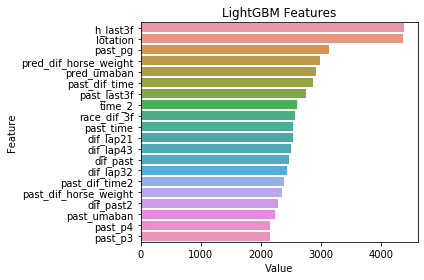

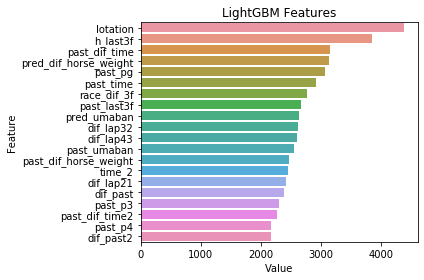

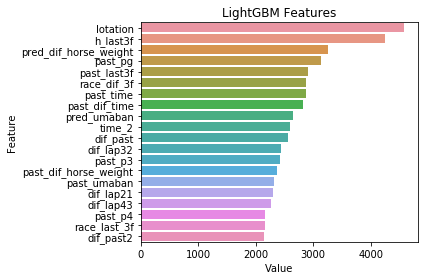

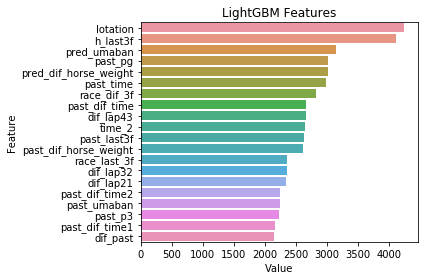

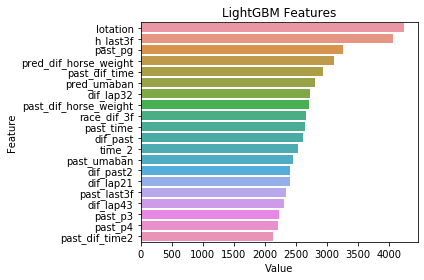

In [806]:
for model in model_set:
    featuer_importance_plot(model,x_columns)

In [68]:
evals_result={}
evals_name=["train_cv_1","eval_cv_1"]
train_data = lgb.Dataset(x_train, label=y_label)
eval_data  = lgb.Dataset(x_eval, label=eval_label, reference= train_data)
model      = lgb.train(params, train_data, valid_names=evals_name,valid_sets=[train_data,eval_data],evals_result=evals_result,verbose_eval=False)

/home/h-kobayashi/anaconda3/envs/mypy/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/h-kobayashi/anaconda3/envs/mypy/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [145]:
def featuer_importance_plot(model,columns):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),columns)), columns=['Value','Feature'])
    plt.figure()
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[0:20,:])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

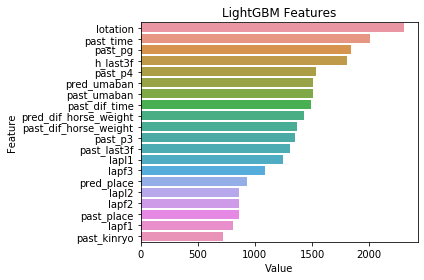

0.499171362280411
0.6981652630314379


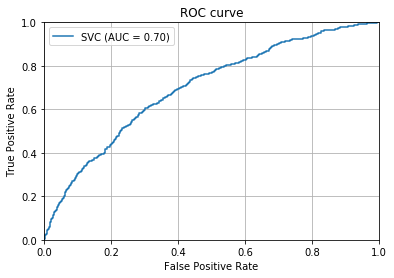

In [197]:
featuer_importance_plot(model,x_columns)
predict_model(model,test.iloc[:,3:-1],test.target.values)

In [320]:
from sklearn import metrics
def predict_model(model,pred_data,pred_target):
    data = model.predict(pred_data)
    acc_data_test =  [1 if i>0.5 else 0 for i in data]
    accuracy = sum(pred_target == acc_data_test) / len(pred_data)
    print(accuracy)
    auc = metrics.roc_auc_score(pred_target, data)
    print(auc)

    fpr, tpr, thresholds = metrics.roc_curve(pred_target, data)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label='SVC (AUC = %.2f)'%auc)
    plt.legend()
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

0.6708036768124754
0.7366849306967979


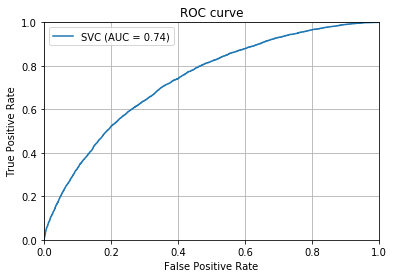

0.6702314102793376
0.7364465360848165


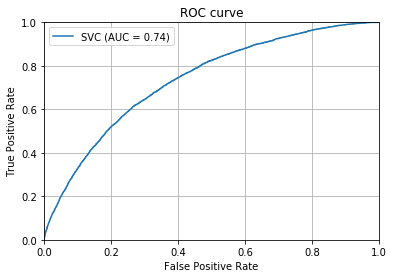

0.6701956436210165
0.7358492151550472


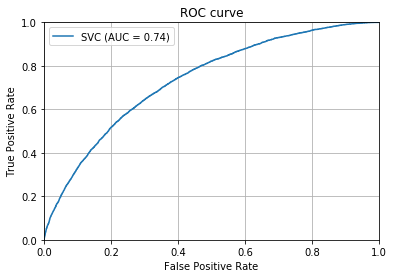

0.6789942415680102
0.7365163683783813


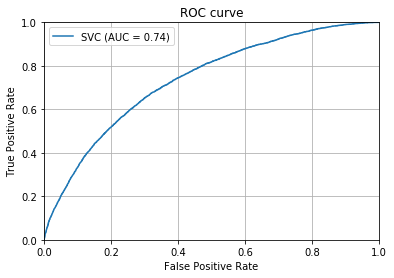

0.6743445759862656
0.7375543680391403


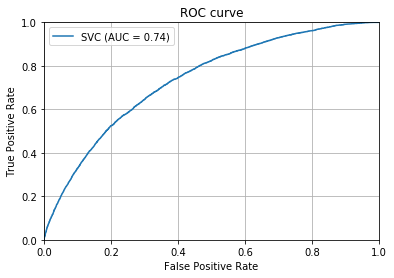

In [807]:
for model in model_set:
    predict_model(model,test.iloc[:,3:-1].values,test.target.values)

dict_keys(['train_cv_1', 'eval_cv_1'])

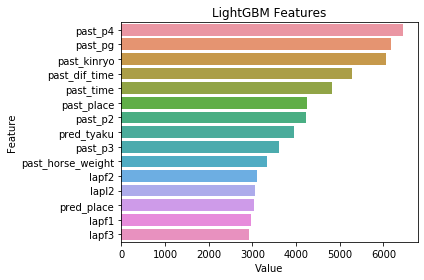

In [288]:
feature_imp1 = feature_imp.iloc[0:10,:]

In [827]:
feature_imp.sort_values(by="Value", ascending=False)

,Value,Feature
36,571,h_last3f
35,506,past_pg
34,465,past_p3
33,449,past_time
32,388,pred_dif_horse_weight
31,372,past_dif_time
30,352,past_last3f
29,324,lotation
28,305,pred_umaban
27,254,pred_horse_years


In [617]:
#lambdarank
#train/label/query, as_index=False
df_p1_rank=df_past1.groupby("pred_race_id").apply(lambda x : x.sort_values(by="pred_umaban"))#.reset_index()

In [747]:
def rank_data_make(group_data):
    train_data = np.zeros(len(group_data),)
    label_data = []
    query_data = []
    c=0
    for name, group in group_data:
        data = group.sort_values(by="pred_umaban")
        train = data.values
        label = [i if i < 7 else 7 for i in data.pred_tyaku.values]
        query = len(data)
        train_data.append(train.tolist())
        label_data.append(label)
        query_data.append(query)
    return train_data,label_data,query_data
g,h,j=rank_data_make(df_past1.groupby("pred_race_id"))


In [748]:
#train_data eval_data 分割
ind = np.arange(0,len(g))
train_index,test_index =  train_test_split(ind,shuffle=True)

In [782]:
def train_split(train_data,test_data):
    train_data_s = []
    test_data_s = []
    for tr,te in zip(train_data,test_data):
        for tr,ter in zip(tr,te):
            train_data_s.append(tr)
            test_data_s.append(ter)
    return train_data_s,test_data_s

In [797]:
train_r = np.array(g)
label_r = np.array(h)
query_r = np.array(j)
print(len(train_r),len(label_r),len(query_r))
train_rank,label_t_rank = train_split(train_r[train_index],label_r[train_index])
train_t_rank = np.array(train_rank)[:,9:35]
label_t_rank = np.array(label_t_rank)
group_t_rank = query_r[train_index]

etra,ela = train_split(train_r[test_index],label_r[test_index])
train_e_rank = np.array(etra)[:,9:35]
label_e_rank = np.array(ela) 
group_e_rank=query_r[test_index]

10809 10809 10809


In [798]:
train_data = lgb.Dataset(train_t_rank, label = label_t_rank ,group=group_t_rank)
eval_data =  lgb.Dataset(train_e_rank ,label = label_e_rank ,group=group_e_rank, reference= train_data)

In [799]:
train_t_rank[:,9:35]

array([[ 0.        ,  0.        ,  0.0625    , ..., 15.        ,
         0.0625    ,  0.056     ],
       [ 0.        ,  0.        ,  0.38888889, ..., 43.        ,
         0.0585    ,  0.0515    ],
       [ 0.375     ,  0.375     ,  0.25      , ..., 28.        ,
         0.0645    ,  0.058     ],
       ...,
       [ 0.06666667,  0.06666667,  0.06666667, ..., 28.        ,
         0.0655    ,  0.062     ],
       [ 0.5       ,  0.5       ,  0.25      , ..., 22.        ,
         0.0655    ,  0.059     ],
       [ 0.25      ,  0.25      ,  0.375     , ..., 28.        ,
         0.0625    ,  0.057     ]])

In [681]:


train_data = lgb.Dataset(train_r[train_index],label = label_r[train_index] ,group=query_r[train_index])
eval_data = lgb.Dataset(train_r[test_index],label = label_r[test_index] ,group=query_r[test_index])

10809 10809 10809


In [802]:
params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'metric': 'ndcg',   # for lambdarank
    'ndcg_eval_at': [1,2,3],  # for lambdarank
    'learning_rate': 0.01,
    'num_iterations':3000,
    'verbosity': -1,
    'early_stopping_rounds': 1000,
}

In [803]:


evals_result={}
evals_name=["train_cv_1","eval_cv_1"]
model      = lgb.train(params, train_data, valid_names=evals_name,valid_sets=[train_data,eval_data],evals_result=evals_result)

[1]	train_cv_1's ndcg@1: 0.846949	train_cv_1's ndcg@2: 0.839185	train_cv_1's ndcg@3: 0.831063	eval_cv_1's ndcg@1: 0.843257	eval_cv_1's ndcg@2: 0.832005	eval_cv_1's ndcg@3: 0.823829
Training until validation scores don't improve for 1000 rounds
[2]	train_cv_1's ndcg@1: 0.857903	train_cv_1's ndcg@2: 0.846296	train_cv_1's ndcg@3: 0.836345	eval_cv_1's ndcg@1: 0.858808	eval_cv_1's ndcg@2: 0.839794	eval_cv_1's ndcg@3: 0.829709
[3]	train_cv_1's ndcg@1: 0.864066	train_cv_1's ndcg@2: 0.849026	train_cv_1's ndcg@3: 0.838238	eval_cv_1's ndcg@1: 0.863402	eval_cv_1's ndcg@2: 0.842749	eval_cv_1's ndcg@3: 0.831753
[4]	train_cv_1's ndcg@1: 0.86754	train_cv_1's ndcg@2: 0.852599	train_cv_1's ndcg@3: 0.840806	eval_cv_1's ndcg@1: 0.86383	eval_cv_1's ndcg@2: 0.843098	eval_cv_1's ndcg@3: 0.832402
[5]	train_cv_1's ndcg@1: 0.868828	train_cv_1's ndcg@2: 0.852317	train_cv_1's ndcg@3: 0.841186	eval_cv_1's ndcg@1: 0.863015	eval_cv_1's ndcg@2: 0.843449	eval_cv_1's ndcg@3: 0.832839
[6]	train_cv_1's ndcg@1: 0.869227	

[57]	train_cv_1's ndcg@1: 0.885932	train_cv_1's ndcg@2: 0.864804	train_cv_1's ndcg@3: 0.851278	eval_cv_1's ndcg@1: 0.865485	eval_cv_1's ndcg@2: 0.848687	eval_cv_1's ndcg@3: 0.837701
[58]	train_cv_1's ndcg@1: 0.885895	train_cv_1's ndcg@2: 0.864798	train_cv_1's ndcg@3: 0.851363	eval_cv_1's ndcg@1: 0.865151	eval_cv_1's ndcg@2: 0.849154	eval_cv_1's ndcg@3: 0.837502
[59]	train_cv_1's ndcg@1: 0.885604	train_cv_1's ndcg@2: 0.864695	train_cv_1's ndcg@3: 0.851492	eval_cv_1's ndcg@1: 0.864499	eval_cv_1's ndcg@2: 0.849043	eval_cv_1's ndcg@3: 0.837641
[60]	train_cv_1's ndcg@1: 0.886253	train_cv_1's ndcg@2: 0.864918	train_cv_1's ndcg@3: 0.851531	eval_cv_1's ndcg@1: 0.865326	eval_cv_1's ndcg@2: 0.849347	eval_cv_1's ndcg@3: 0.837333
[61]	train_cv_1's ndcg@1: 0.886164	train_cv_1's ndcg@2: 0.86486	train_cv_1's ndcg@3: 0.851678	eval_cv_1's ndcg@1: 0.866434	eval_cv_1's ndcg@2: 0.849757	eval_cv_1's ndcg@3: 0.837589
[62]	train_cv_1's ndcg@1: 0.886562	train_cv_1's ndcg@2: 0.86505	train_cv_1's ndcg@3: 0.8517

[109]	train_cv_1's ndcg@1: 0.89601	train_cv_1's ndcg@2: 0.871737	train_cv_1's ndcg@3: 0.857173	eval_cv_1's ndcg@1: 0.871229	eval_cv_1's ndcg@2: 0.852615	eval_cv_1's ndcg@3: 0.841119
[110]	train_cv_1's ndcg@1: 0.895709	train_cv_1's ndcg@2: 0.87161	train_cv_1's ndcg@3: 0.857217	eval_cv_1's ndcg@1: 0.87187	eval_cv_1's ndcg@2: 0.852481	eval_cv_1's ndcg@3: 0.841123
[111]	train_cv_1's ndcg@1: 0.895497	train_cv_1's ndcg@2: 0.871576	train_cv_1's ndcg@3: 0.857207	eval_cv_1's ndcg@1: 0.871288	eval_cv_1's ndcg@2: 0.852382	eval_cv_1's ndcg@3: 0.84098
[112]	train_cv_1's ndcg@1: 0.895565	train_cv_1's ndcg@2: 0.871821	train_cv_1's ndcg@3: 0.857268	eval_cv_1's ndcg@1: 0.871346	eval_cv_1's ndcg@2: 0.85247	eval_cv_1's ndcg@3: 0.841334
[113]	train_cv_1's ndcg@1: 0.895822	train_cv_1's ndcg@2: 0.871921	train_cv_1's ndcg@3: 0.857215	eval_cv_1's ndcg@1: 0.871509	eval_cv_1's ndcg@2: 0.852334	eval_cv_1's ndcg@3: 0.841389
[114]	train_cv_1's ndcg@1: 0.896305	train_cv_1's ndcg@2: 0.872023	train_cv_1's ndcg@3: 0.8

[167]	train_cv_1's ndcg@1: 0.905592	train_cv_1's ndcg@2: 0.87995	train_cv_1's ndcg@3: 0.863522	eval_cv_1's ndcg@1: 0.875067	eval_cv_1's ndcg@2: 0.855657	eval_cv_1's ndcg@3: 0.843567
[168]	train_cv_1's ndcg@1: 0.905868	train_cv_1's ndcg@2: 0.879866	train_cv_1's ndcg@3: 0.863648	eval_cv_1's ndcg@1: 0.875393	eval_cv_1's ndcg@2: 0.855523	eval_cv_1's ndcg@3: 0.843838
[169]	train_cv_1's ndcg@1: 0.905899	train_cv_1's ndcg@2: 0.880066	train_cv_1's ndcg@3: 0.863791	eval_cv_1's ndcg@1: 0.875393	eval_cv_1's ndcg@2: 0.855388	eval_cv_1's ndcg@3: 0.843695
[170]	train_cv_1's ndcg@1: 0.906299	train_cv_1's ndcg@2: 0.880309	train_cv_1's ndcg@3: 0.864054	eval_cv_1's ndcg@1: 0.876057	eval_cv_1's ndcg@2: 0.855363	eval_cv_1's ndcg@3: 0.843615
[171]	train_cv_1's ndcg@1: 0.906466	train_cv_1's ndcg@2: 0.880282	train_cv_1's ndcg@3: 0.864148	eval_cv_1's ndcg@1: 0.875614	eval_cv_1's ndcg@2: 0.855371	eval_cv_1's ndcg@3: 0.843617
[172]	train_cv_1's ndcg@1: 0.906556	train_cv_1's ndcg@2: 0.88029	train_cv_1's ndcg@3: 

[224]	train_cv_1's ndcg@1: 0.912783	train_cv_1's ndcg@2: 0.885138	train_cv_1's ndcg@3: 0.868556	eval_cv_1's ndcg@1: 0.876016	eval_cv_1's ndcg@2: 0.858169	eval_cv_1's ndcg@3: 0.845326
[225]	train_cv_1's ndcg@1: 0.912923	train_cv_1's ndcg@2: 0.885264	train_cv_1's ndcg@3: 0.868625	eval_cv_1's ndcg@1: 0.876203	eval_cv_1's ndcg@2: 0.857977	eval_cv_1's ndcg@3: 0.845272
[226]	train_cv_1's ndcg@1: 0.912923	train_cv_1's ndcg@2: 0.885309	train_cv_1's ndcg@3: 0.86878	eval_cv_1's ndcg@1: 0.876657	eval_cv_1's ndcg@2: 0.858082	eval_cv_1's ndcg@3: 0.845368
[227]	train_cv_1's ndcg@1: 0.91314	train_cv_1's ndcg@2: 0.885371	train_cv_1's ndcg@3: 0.868974	eval_cv_1's ndcg@1: 0.876912	eval_cv_1's ndcg@2: 0.857901	eval_cv_1's ndcg@3: 0.844922
[228]	train_cv_1's ndcg@1: 0.913047	train_cv_1's ndcg@2: 0.885365	train_cv_1's ndcg@3: 0.868772	eval_cv_1's ndcg@1: 0.876306	eval_cv_1's ndcg@2: 0.857371	eval_cv_1's ndcg@3: 0.844715
[229]	train_cv_1's ndcg@1: 0.912977	train_cv_1's ndcg@2: 0.885565	train_cv_1's ndcg@3: 

[284]	train_cv_1's ndcg@1: 0.917899	train_cv_1's ndcg@2: 0.88962	train_cv_1's ndcg@3: 0.872269	eval_cv_1's ndcg@1: 0.882004	eval_cv_1's ndcg@2: 0.860324	eval_cv_1's ndcg@3: 0.847407
[285]	train_cv_1's ndcg@1: 0.91805	train_cv_1's ndcg@2: 0.889827	train_cv_1's ndcg@3: 0.872375	eval_cv_1's ndcg@1: 0.881025	eval_cv_1's ndcg@2: 0.86008	eval_cv_1's ndcg@3: 0.84715
[286]	train_cv_1's ndcg@1: 0.918019	train_cv_1's ndcg@2: 0.889911	train_cv_1's ndcg@3: 0.872572	eval_cv_1's ndcg@1: 0.881165	eval_cv_1's ndcg@2: 0.85997	eval_cv_1's ndcg@3: 0.847093
[287]	train_cv_1's ndcg@1: 0.918136	train_cv_1's ndcg@2: 0.889693	train_cv_1's ndcg@3: 0.872602	eval_cv_1's ndcg@1: 0.881765	eval_cv_1's ndcg@2: 0.860387	eval_cv_1's ndcg@3: 0.847212
[288]	train_cv_1's ndcg@1: 0.918206	train_cv_1's ndcg@2: 0.889912	train_cv_1's ndcg@3: 0.872746	eval_cv_1's ndcg@1: 0.881579	eval_cv_1's ndcg@2: 0.860077	eval_cv_1's ndcg@3: 0.847063
[289]	train_cv_1's ndcg@1: 0.918179	train_cv_1's ndcg@2: 0.889935	train_cv_1's ndcg@3: 0.8

[347]	train_cv_1's ndcg@1: 0.922977	train_cv_1's ndcg@2: 0.89456	train_cv_1's ndcg@3: 0.876286	eval_cv_1's ndcg@1: 0.882569	eval_cv_1's ndcg@2: 0.862657	eval_cv_1's ndcg@3: 0.848689
[348]	train_cv_1's ndcg@1: 0.92316	train_cv_1's ndcg@2: 0.894681	train_cv_1's ndcg@3: 0.876391	eval_cv_1's ndcg@1: 0.882843	eval_cv_1's ndcg@2: 0.862802	eval_cv_1's ndcg@3: 0.848657
[349]	train_cv_1's ndcg@1: 0.923222	train_cv_1's ndcg@2: 0.894743	train_cv_1's ndcg@3: 0.876448	eval_cv_1's ndcg@1: 0.882656	eval_cv_1's ndcg@2: 0.862819	eval_cv_1's ndcg@3: 0.848598
[350]	train_cv_1's ndcg@1: 0.92335	train_cv_1's ndcg@2: 0.894867	train_cv_1's ndcg@3: 0.876505	eval_cv_1's ndcg@1: 0.882196	eval_cv_1's ndcg@2: 0.862725	eval_cv_1's ndcg@3: 0.848631
[351]	train_cv_1's ndcg@1: 0.923432	train_cv_1's ndcg@2: 0.894911	train_cv_1's ndcg@3: 0.876535	eval_cv_1's ndcg@1: 0.882563	eval_cv_1's ndcg@2: 0.863076	eval_cv_1's ndcg@3: 0.848598
[352]	train_cv_1's ndcg@1: 0.92363	train_cv_1's ndcg@2: 0.895024	train_cv_1's ndcg@3: 0.

[413]	train_cv_1's ndcg@1: 0.927727	train_cv_1's ndcg@2: 0.899335	train_cv_1's ndcg@3: 0.879715	eval_cv_1's ndcg@1: 0.883142	eval_cv_1's ndcg@2: 0.863567	eval_cv_1's ndcg@3: 0.848906
[414]	train_cv_1's ndcg@1: 0.92769	train_cv_1's ndcg@2: 0.899355	train_cv_1's ndcg@3: 0.879777	eval_cv_1's ndcg@1: 0.883142	eval_cv_1's ndcg@2: 0.863333	eval_cv_1's ndcg@3: 0.848873
[415]	train_cv_1's ndcg@1: 0.927922	train_cv_1's ndcg@2: 0.899612	train_cv_1's ndcg@3: 0.879842	eval_cv_1's ndcg@1: 0.883853	eval_cv_1's ndcg@2: 0.863796	eval_cv_1's ndcg@3: 0.848993
[416]	train_cv_1's ndcg@1: 0.928042	train_cv_1's ndcg@2: 0.899632	train_cv_1's ndcg@3: 0.879943	eval_cv_1's ndcg@1: 0.883853	eval_cv_1's ndcg@2: 0.86408	eval_cv_1's ndcg@3: 0.849045
[417]	train_cv_1's ndcg@1: 0.928042	train_cv_1's ndcg@2: 0.899573	train_cv_1's ndcg@3: 0.879954	eval_cv_1's ndcg@1: 0.883853	eval_cv_1's ndcg@2: 0.863954	eval_cv_1's ndcg@3: 0.849135
[418]	train_cv_1's ndcg@1: 0.928038	train_cv_1's ndcg@2: 0.899512	train_cv_1's ndcg@3: 

[479]	train_cv_1's ndcg@1: 0.931543	train_cv_1's ndcg@2: 0.903633	train_cv_1's ndcg@3: 0.883376	eval_cv_1's ndcg@1: 0.88417	eval_cv_1's ndcg@2: 0.865444	eval_cv_1's ndcg@3: 0.850317
[480]	train_cv_1's ndcg@1: 0.931535	train_cv_1's ndcg@2: 0.903632	train_cv_1's ndcg@3: 0.883418	eval_cv_1's ndcg@1: 0.88417	eval_cv_1's ndcg@2: 0.86557	eval_cv_1's ndcg@3: 0.850376
[481]	train_cv_1's ndcg@1: 0.931535	train_cv_1's ndcg@2: 0.90369	train_cv_1's ndcg@3: 0.883433	eval_cv_1's ndcg@1: 0.884356	eval_cv_1's ndcg@2: 0.865865	eval_cv_1's ndcg@3: 0.850514
[482]	train_cv_1's ndcg@1: 0.931529	train_cv_1's ndcg@2: 0.9038	train_cv_1's ndcg@3: 0.883528	eval_cv_1's ndcg@1: 0.884356	eval_cv_1's ndcg@2: 0.86573	eval_cv_1's ndcg@3: 0.850539
[483]	train_cv_1's ndcg@1: 0.931599	train_cv_1's ndcg@2: 0.903888	train_cv_1's ndcg@3: 0.883584	eval_cv_1's ndcg@1: 0.885079	eval_cv_1's ndcg@2: 0.866029	eval_cv_1's ndcg@3: 0.85089
[484]	train_cv_1's ndcg@1: 0.931597	train_cv_1's ndcg@2: 0.903864	train_cv_1's ndcg@3: 0.8835

[541]	train_cv_1's ndcg@1: 0.935801	train_cv_1's ndcg@2: 0.906668	train_cv_1's ndcg@3: 0.88593	eval_cv_1's ndcg@1: 0.886291	eval_cv_1's ndcg@2: 0.865385	eval_cv_1's ndcg@3: 0.851614
[542]	train_cv_1's ndcg@1: 0.935801	train_cv_1's ndcg@2: 0.906737	train_cv_1's ndcg@3: 0.886023	eval_cv_1's ndcg@1: 0.886291	eval_cv_1's ndcg@2: 0.865651	eval_cv_1's ndcg@3: 0.851738
[543]	train_cv_1's ndcg@1: 0.935801	train_cv_1's ndcg@2: 0.906922	train_cv_1's ndcg@3: 0.88606	eval_cv_1's ndcg@1: 0.885825	eval_cv_1's ndcg@2: 0.865545	eval_cv_1's ndcg@3: 0.851657
[544]	train_cv_1's ndcg@1: 0.936042	train_cv_1's ndcg@2: 0.906931	train_cv_1's ndcg@3: 0.886119	eval_cv_1's ndcg@1: 0.885219	eval_cv_1's ndcg@2: 0.865336	eval_cv_1's ndcg@3: 0.851667
[545]	train_cv_1's ndcg@1: 0.936151	train_cv_1's ndcg@2: 0.907067	train_cv_1's ndcg@3: 0.886118	eval_cv_1's ndcg@1: 0.885755	eval_cv_1's ndcg@2: 0.865579	eval_cv_1's ndcg@3: 0.851635
[546]	train_cv_1's ndcg@1: 0.935994	train_cv_1's ndcg@2: 0.907017	train_cv_1's ndcg@3: 

[596]	train_cv_1's ndcg@1: 0.93857	train_cv_1's ndcg@2: 0.909656	train_cv_1's ndcg@3: 0.888244	eval_cv_1's ndcg@1: 0.884974	eval_cv_1's ndcg@2: 0.866032	eval_cv_1's ndcg@3: 0.851709
[597]	train_cv_1's ndcg@1: 0.938899	train_cv_1's ndcg@2: 0.909729	train_cv_1's ndcg@3: 0.888355	eval_cv_1's ndcg@1: 0.884974	eval_cv_1's ndcg@2: 0.866066	eval_cv_1's ndcg@3: 0.851741
[598]	train_cv_1's ndcg@1: 0.939029	train_cv_1's ndcg@2: 0.909763	train_cv_1's ndcg@3: 0.888384	eval_cv_1's ndcg@1: 0.885254	eval_cv_1's ndcg@2: 0.866104	eval_cv_1's ndcg@3: 0.851687
[599]	train_cv_1's ndcg@1: 0.939175	train_cv_1's ndcg@2: 0.90983	train_cv_1's ndcg@3: 0.888508	eval_cv_1's ndcg@1: 0.885067	eval_cv_1's ndcg@2: 0.866098	eval_cv_1's ndcg@3: 0.851687
[600]	train_cv_1's ndcg@1: 0.939089	train_cv_1's ndcg@2: 0.909948	train_cv_1's ndcg@3: 0.888495	eval_cv_1's ndcg@1: 0.884158	eval_cv_1's ndcg@2: 0.865699	eval_cv_1's ndcg@3: 0.851545
[601]	train_cv_1's ndcg@1: 0.939122	train_cv_1's ndcg@2: 0.909998	train_cv_1's ndcg@3: 

[654]	train_cv_1's ndcg@1: 0.941867	train_cv_1's ndcg@2: 0.912831	train_cv_1's ndcg@3: 0.890577	eval_cv_1's ndcg@1: 0.885737	eval_cv_1's ndcg@2: 0.865662	eval_cv_1's ndcg@3: 0.852577
[655]	train_cv_1's ndcg@1: 0.941929	train_cv_1's ndcg@2: 0.912845	train_cv_1's ndcg@3: 0.890659	eval_cv_1's ndcg@1: 0.885737	eval_cv_1's ndcg@2: 0.865451	eval_cv_1's ndcg@3: 0.852565
[656]	train_cv_1's ndcg@1: 0.941935	train_cv_1's ndcg@2: 0.912888	train_cv_1's ndcg@3: 0.890587	eval_cv_1's ndcg@1: 0.885364	eval_cv_1's ndcg@2: 0.865492	eval_cv_1's ndcg@3: 0.852583
[657]	train_cv_1's ndcg@1: 0.942091	train_cv_1's ndcg@2: 0.91296	train_cv_1's ndcg@3: 0.890584	eval_cv_1's ndcg@1: 0.885551	eval_cv_1's ndcg@2: 0.865535	eval_cv_1's ndcg@3: 0.852616
[658]	train_cv_1's ndcg@1: 0.942085	train_cv_1's ndcg@2: 0.913	train_cv_1's ndcg@3: 0.890721	eval_cv_1's ndcg@1: 0.885708	eval_cv_1's ndcg@2: 0.865712	eval_cv_1's ndcg@3: 0.852845
[659]	train_cv_1's ndcg@1: 0.942085	train_cv_1's ndcg@2: 0.913058	train_cv_1's ndcg@3: 0.

[715]	train_cv_1's ndcg@1: 0.945086	train_cv_1's ndcg@2: 0.915582	train_cv_1's ndcg@3: 0.893446	eval_cv_1's ndcg@1: 0.886122	eval_cv_1's ndcg@2: 0.865642	eval_cv_1's ndcg@3: 0.853207
[716]	train_cv_1's ndcg@1: 0.94509	train_cv_1's ndcg@2: 0.915565	train_cv_1's ndcg@3: 0.893433	eval_cv_1's ndcg@1: 0.886122	eval_cv_1's ndcg@2: 0.865642	eval_cv_1's ndcg@3: 0.853128
[717]	train_cv_1's ndcg@1: 0.94509	train_cv_1's ndcg@2: 0.915622	train_cv_1's ndcg@3: 0.893464	eval_cv_1's ndcg@1: 0.885842	eval_cv_1's ndcg@2: 0.865552	eval_cv_1's ndcg@3: 0.853037
[718]	train_cv_1's ndcg@1: 0.945149	train_cv_1's ndcg@2: 0.915666	train_cv_1's ndcg@3: 0.893496	eval_cv_1's ndcg@1: 0.886005	eval_cv_1's ndcg@2: 0.865652	eval_cv_1's ndcg@3: 0.853152
[719]	train_cv_1's ndcg@1: 0.945149	train_cv_1's ndcg@2: 0.915744	train_cv_1's ndcg@3: 0.893603	eval_cv_1's ndcg@1: 0.886005	eval_cv_1's ndcg@2: 0.865485	eval_cv_1's ndcg@3: 0.853125
[720]	train_cv_1's ndcg@1: 0.945149	train_cv_1's ndcg@2: 0.915831	train_cv_1's ndcg@3: 

[778]	train_cv_1's ndcg@1: 0.947699	train_cv_1's ndcg@2: 0.918309	train_cv_1's ndcg@3: 0.896389	eval_cv_1's ndcg@1: 0.887036	eval_cv_1's ndcg@2: 0.866395	eval_cv_1's ndcg@3: 0.853539
[779]	train_cv_1's ndcg@1: 0.947699	train_cv_1's ndcg@2: 0.918332	train_cv_1's ndcg@3: 0.89636	eval_cv_1's ndcg@1: 0.887036	eval_cv_1's ndcg@2: 0.86626	eval_cv_1's ndcg@3: 0.853517
[780]	train_cv_1's ndcg@1: 0.947762	train_cv_1's ndcg@2: 0.918401	train_cv_1's ndcg@3: 0.896436	eval_cv_1's ndcg@1: 0.887036	eval_cv_1's ndcg@2: 0.866244	eval_cv_1's ndcg@3: 0.853515
[781]	train_cv_1's ndcg@1: 0.947762	train_cv_1's ndcg@2: 0.918443	train_cv_1's ndcg@3: 0.896454	eval_cv_1's ndcg@1: 0.887036	eval_cv_1's ndcg@2: 0.866244	eval_cv_1's ndcg@3: 0.853515
[782]	train_cv_1's ndcg@1: 0.947855	train_cv_1's ndcg@2: 0.918411	train_cv_1's ndcg@3: 0.896471	eval_cv_1's ndcg@1: 0.886664	eval_cv_1's ndcg@2: 0.866232	eval_cv_1's ndcg@3: 0.853503
[783]	train_cv_1's ndcg@1: 0.947855	train_cv_1's ndcg@2: 0.918591	train_cv_1's ndcg@3: 

[842]	train_cv_1's ndcg@1: 0.95066	train_cv_1's ndcg@2: 0.92113	train_cv_1's ndcg@3: 0.898738	eval_cv_1's ndcg@1: 0.887526	eval_cv_1's ndcg@2: 0.866729	eval_cv_1's ndcg@3: 0.854092
[843]	train_cv_1's ndcg@1: 0.95066	train_cv_1's ndcg@2: 0.921154	train_cv_1's ndcg@3: 0.898742	eval_cv_1's ndcg@1: 0.888023	eval_cv_1's ndcg@2: 0.866747	eval_cv_1's ndcg@3: 0.854219
[844]	train_cv_1's ndcg@1: 0.95066	train_cv_1's ndcg@2: 0.921154	train_cv_1's ndcg@3: 0.898769	eval_cv_1's ndcg@1: 0.88821	eval_cv_1's ndcg@2: 0.866773	eval_cv_1's ndcg@3: 0.854292
[845]	train_cv_1's ndcg@1: 0.95066	train_cv_1's ndcg@2: 0.921291	train_cv_1's ndcg@3: 0.898838	eval_cv_1's ndcg@1: 0.887843	eval_cv_1's ndcg@2: 0.866519	eval_cv_1's ndcg@3: 0.854193
[846]	train_cv_1's ndcg@1: 0.95066	train_cv_1's ndcg@2: 0.921336	train_cv_1's ndcg@3: 0.898845	eval_cv_1's ndcg@1: 0.887475	eval_cv_1's ndcg@2: 0.866576	eval_cv_1's ndcg@3: 0.854305
[847]	train_cv_1's ndcg@1: 0.950862	train_cv_1's ndcg@2: 0.921328	train_cv_1's ndcg@3: 0.898

[906]	train_cv_1's ndcg@1: 0.952671	train_cv_1's ndcg@2: 0.923404	train_cv_1's ndcg@3: 0.900968	eval_cv_1's ndcg@1: 0.890365	eval_cv_1's ndcg@2: 0.867268	eval_cv_1's ndcg@3: 0.855157
[907]	train_cv_1's ndcg@1: 0.952671	train_cv_1's ndcg@2: 0.923467	train_cv_1's ndcg@3: 0.90099	eval_cv_1's ndcg@1: 0.890365	eval_cv_1's ndcg@2: 0.867268	eval_cv_1's ndcg@3: 0.855373
[908]	train_cv_1's ndcg@1: 0.952671	train_cv_1's ndcg@2: 0.923535	train_cv_1's ndcg@3: 0.901	eval_cv_1's ndcg@1: 0.890365	eval_cv_1's ndcg@2: 0.867268	eval_cv_1's ndcg@3: 0.85553
[909]	train_cv_1's ndcg@1: 0.952671	train_cv_1's ndcg@2: 0.923638	train_cv_1's ndcg@3: 0.901016	eval_cv_1's ndcg@1: 0.890365	eval_cv_1's ndcg@2: 0.867268	eval_cv_1's ndcg@3: 0.855445
[910]	train_cv_1's ndcg@1: 0.952671	train_cv_1's ndcg@2: 0.923638	train_cv_1's ndcg@3: 0.901023	eval_cv_1's ndcg@1: 0.890365	eval_cv_1's ndcg@2: 0.867268	eval_cv_1's ndcg@3: 0.855478
[911]	train_cv_1's ndcg@1: 0.952656	train_cv_1's ndcg@2: 0.923634	train_cv_1's ndcg@3: 0.9

[969]	train_cv_1's ndcg@1: 0.953596	train_cv_1's ndcg@2: 0.925954	train_cv_1's ndcg@3: 0.902812	eval_cv_1's ndcg@1: 0.889485	eval_cv_1's ndcg@2: 0.867368	eval_cv_1's ndcg@3: 0.855461
[970]	train_cv_1's ndcg@1: 0.953689	train_cv_1's ndcg@2: 0.925975	train_cv_1's ndcg@3: 0.902829	eval_cv_1's ndcg@1: 0.889485	eval_cv_1's ndcg@2: 0.86744	eval_cv_1's ndcg@3: 0.855472
[971]	train_cv_1's ndcg@1: 0.953689	train_cv_1's ndcg@2: 0.925987	train_cv_1's ndcg@3: 0.902824	eval_cv_1's ndcg@1: 0.889485	eval_cv_1's ndcg@2: 0.867567	eval_cv_1's ndcg@3: 0.855493
[972]	train_cv_1's ndcg@1: 0.953783	train_cv_1's ndcg@2: 0.926032	train_cv_1's ndcg@3: 0.902844	eval_cv_1's ndcg@1: 0.889485	eval_cv_1's ndcg@2: 0.867738	eval_cv_1's ndcg@3: 0.855563
[973]	train_cv_1's ndcg@1: 0.953783	train_cv_1's ndcg@2: 0.926056	train_cv_1's ndcg@3: 0.902863	eval_cv_1's ndcg@1: 0.889485	eval_cv_1's ndcg@2: 0.867738	eval_cv_1's ndcg@3: 0.855563
[974]	train_cv_1's ndcg@1: 0.953891	train_cv_1's ndcg@2: 0.926123	train_cv_1's ndcg@3:

[1023]	train_cv_1's ndcg@1: 0.955652	train_cv_1's ndcg@2: 0.928268	train_cv_1's ndcg@3: 0.904537	eval_cv_1's ndcg@1: 0.89127	eval_cv_1's ndcg@2: 0.869018	eval_cv_1's ndcg@3: 0.85616
[1024]	train_cv_1's ndcg@1: 0.955714	train_cv_1's ndcg@2: 0.928336	train_cv_1's ndcg@3: 0.904556	eval_cv_1's ndcg@1: 0.891456	eval_cv_1's ndcg@2: 0.868988	eval_cv_1's ndcg@3: 0.856095
[1025]	train_cv_1's ndcg@1: 0.955927	train_cv_1's ndcg@2: 0.928443	train_cv_1's ndcg@3: 0.904647	eval_cv_1's ndcg@1: 0.89127	eval_cv_1's ndcg@2: 0.868695	eval_cv_1's ndcg@3: 0.856023
[1026]	train_cv_1's ndcg@1: 0.956048	train_cv_1's ndcg@2: 0.928516	train_cv_1's ndcg@3: 0.904661	eval_cv_1's ndcg@1: 0.89127	eval_cv_1's ndcg@2: 0.868835	eval_cv_1's ndcg@3: 0.856009
[1027]	train_cv_1's ndcg@1: 0.956048	train_cv_1's ndcg@2: 0.928516	train_cv_1's ndcg@3: 0.904715	eval_cv_1's ndcg@1: 0.89127	eval_cv_1's ndcg@2: 0.868835	eval_cv_1's ndcg@3: 0.856008
[1028]	train_cv_1's ndcg@1: 0.95611	train_cv_1's ndcg@2: 0.92853	train_cv_1's ndcg@3:

[1076]	train_cv_1's ndcg@1: 0.956997	train_cv_1's ndcg@2: 0.930095	train_cv_1's ndcg@3: 0.9063	eval_cv_1's ndcg@1: 0.890291	eval_cv_1's ndcg@2: 0.867913	eval_cv_1's ndcg@3: 0.855714
[1077]	train_cv_1's ndcg@1: 0.956997	train_cv_1's ndcg@2: 0.930148	train_cv_1's ndcg@3: 0.90633	eval_cv_1's ndcg@1: 0.889924	eval_cv_1's ndcg@2: 0.867688	eval_cv_1's ndcg@3: 0.855619
[1078]	train_cv_1's ndcg@1: 0.957003	train_cv_1's ndcg@2: 0.930184	train_cv_1's ndcg@3: 0.906413	eval_cv_1's ndcg@1: 0.889736	eval_cv_1's ndcg@2: 0.867777	eval_cv_1's ndcg@3: 0.855659
[1079]	train_cv_1's ndcg@1: 0.957003	train_cv_1's ndcg@2: 0.930172	train_cv_1's ndcg@3: 0.906455	eval_cv_1's ndcg@1: 0.890103	eval_cv_1's ndcg@2: 0.86786	eval_cv_1's ndcg@3: 0.855797
[1080]	train_cv_1's ndcg@1: 0.957003	train_cv_1's ndcg@2: 0.930365	train_cv_1's ndcg@3: 0.906489	eval_cv_1's ndcg@1: 0.889823	eval_cv_1's ndcg@2: 0.867939	eval_cv_1's ndcg@3: 0.855886
[1081]	train_cv_1's ndcg@1: 0.957003	train_cv_1's ndcg@2: 0.930401	train_cv_1's ndcg

[1121]	train_cv_1's ndcg@1: 0.958672	train_cv_1's ndcg@2: 0.931775	train_cv_1's ndcg@3: 0.907619	eval_cv_1's ndcg@1: 0.890052	eval_cv_1's ndcg@2: 0.867809	eval_cv_1's ndcg@3: 0.855804
[1122]	train_cv_1's ndcg@1: 0.958765	train_cv_1's ndcg@2: 0.931843	train_cv_1's ndcg@3: 0.907664	eval_cv_1's ndcg@1: 0.889726	eval_cv_1's ndcg@2: 0.867737	eval_cv_1's ndcg@3: 0.855748
[1123]	train_cv_1's ndcg@1: 0.958765	train_cv_1's ndcg@2: 0.931913	train_cv_1's ndcg@3: 0.90769	eval_cv_1's ndcg@1: 0.889912	eval_cv_1's ndcg@2: 0.867644	eval_cv_1's ndcg@3: 0.855693
[1124]	train_cv_1's ndcg@1: 0.958859	train_cv_1's ndcg@2: 0.931981	train_cv_1's ndcg@3: 0.907735	eval_cv_1's ndcg@1: 0.889912	eval_cv_1's ndcg@2: 0.867644	eval_cv_1's ndcg@3: 0.855696
[1125]	train_cv_1's ndcg@1: 0.958859	train_cv_1's ndcg@2: 0.932026	train_cv_1's ndcg@3: 0.907735	eval_cv_1's ndcg@1: 0.889586	eval_cv_1's ndcg@2: 0.867431	eval_cv_1's ndcg@3: 0.855597
[1126]	train_cv_1's ndcg@1: 0.958859	train_cv_1's ndcg@2: 0.932068	train_cv_1's n

[1174]	train_cv_1's ndcg@1: 0.960224	train_cv_1's ndcg@2: 0.933397	train_cv_1's ndcg@3: 0.909624	eval_cv_1's ndcg@1: 0.890192	eval_cv_1's ndcg@2: 0.868704	eval_cv_1's ndcg@3: 0.856566
[1175]	train_cv_1's ndcg@1: 0.960224	train_cv_1's ndcg@2: 0.933373	train_cv_1's ndcg@3: 0.909702	eval_cv_1's ndcg@1: 0.890005	eval_cv_1's ndcg@2: 0.868594	eval_cv_1's ndcg@3: 0.856604
[1176]	train_cv_1's ndcg@1: 0.960224	train_cv_1's ndcg@2: 0.933373	train_cv_1's ndcg@3: 0.909702	eval_cv_1's ndcg@1: 0.889819	eval_cv_1's ndcg@2: 0.868624	eval_cv_1's ndcg@3: 0.856583
[1177]	train_cv_1's ndcg@1: 0.960224	train_cv_1's ndcg@2: 0.933415	train_cv_1's ndcg@3: 0.909711	eval_cv_1's ndcg@1: 0.889819	eval_cv_1's ndcg@2: 0.868691	eval_cv_1's ndcg@3: 0.856514
[1178]	train_cv_1's ndcg@1: 0.960224	train_cv_1's ndcg@2: 0.933415	train_cv_1's ndcg@3: 0.909726	eval_cv_1's ndcg@1: 0.889819	eval_cv_1's ndcg@2: 0.868583	eval_cv_1's ndcg@3: 0.856421
[1179]	train_cv_1's ndcg@1: 0.960224	train_cv_1's ndcg@2: 0.933415	train_cv_1's 

[1224]	train_cv_1's ndcg@1: 0.96134	train_cv_1's ndcg@2: 0.934845	train_cv_1's ndcg@3: 0.910907	eval_cv_1's ndcg@1: 0.89032	eval_cv_1's ndcg@2: 0.868698	eval_cv_1's ndcg@3: 0.855703
[1225]	train_cv_1's ndcg@1: 0.96134	train_cv_1's ndcg@2: 0.934963	train_cv_1's ndcg@3: 0.910931	eval_cv_1's ndcg@1: 0.890279	eval_cv_1's ndcg@2: 0.868716	eval_cv_1's ndcg@3: 0.855676
[1226]	train_cv_1's ndcg@1: 0.96134	train_cv_1's ndcg@2: 0.934987	train_cv_1's ndcg@3: 0.910985	eval_cv_1's ndcg@1: 0.890279	eval_cv_1's ndcg@2: 0.86859	eval_cv_1's ndcg@3: 0.85557
[1227]	train_cv_1's ndcg@1: 0.96134	train_cv_1's ndcg@2: 0.935058	train_cv_1's ndcg@3: 0.911023	eval_cv_1's ndcg@1: 0.890093	eval_cv_1's ndcg@2: 0.868548	eval_cv_1's ndcg@3: 0.855538
[1228]	train_cv_1's ndcg@1: 0.96134	train_cv_1's ndcg@2: 0.935094	train_cv_1's ndcg@3: 0.911056	eval_cv_1's ndcg@1: 0.890093	eval_cv_1's ndcg@2: 0.868656	eval_cv_1's ndcg@3: 0.855637
[1229]	train_cv_1's ndcg@1: 0.96134	train_cv_1's ndcg@2: 0.935141	train_cv_1's ndcg@3: 0

[1269]	train_cv_1's ndcg@1: 0.961724	train_cv_1's ndcg@2: 0.935749	train_cv_1's ndcg@3: 0.911881	eval_cv_1's ndcg@1: 0.889714	eval_cv_1's ndcg@2: 0.868706	eval_cv_1's ndcg@3: 0.855886
[1270]	train_cv_1's ndcg@1: 0.961724	train_cv_1's ndcg@2: 0.935788	train_cv_1's ndcg@3: 0.911887	eval_cv_1's ndcg@1: 0.889714	eval_cv_1's ndcg@2: 0.868706	eval_cv_1's ndcg@3: 0.855801
[1271]	train_cv_1's ndcg@1: 0.961724	train_cv_1's ndcg@2: 0.935794	train_cv_1's ndcg@3: 0.911895	eval_cv_1's ndcg@1: 0.889714	eval_cv_1's ndcg@2: 0.868706	eval_cv_1's ndcg@3: 0.855801
[1272]	train_cv_1's ndcg@1: 0.961771	train_cv_1's ndcg@2: 0.935805	train_cv_1's ndcg@3: 0.911903	eval_cv_1's ndcg@1: 0.889714	eval_cv_1's ndcg@2: 0.868706	eval_cv_1's ndcg@3: 0.855886
[1273]	train_cv_1's ndcg@1: 0.961957	train_cv_1's ndcg@2: 0.935847	train_cv_1's ndcg@3: 0.911992	eval_cv_1's ndcg@1: 0.889347	eval_cv_1's ndcg@2: 0.868761	eval_cv_1's ndcg@3: 0.855759
[1274]	train_cv_1's ndcg@1: 0.961957	train_cv_1's ndcg@2: 0.935943	train_cv_1's 

[1315]	train_cv_1's ndcg@1: 0.963515	train_cv_1's ndcg@2: 0.937205	train_cv_1's ndcg@3: 0.913168	eval_cv_1's ndcg@1: 0.889732	eval_cv_1's ndcg@2: 0.868217	eval_cv_1's ndcg@3: 0.85569
[1316]	train_cv_1's ndcg@1: 0.963636	train_cv_1's ndcg@2: 0.937233	train_cv_1's ndcg@3: 0.913204	eval_cv_1's ndcg@1: 0.889732	eval_cv_1's ndcg@2: 0.868217	eval_cv_1's ndcg@3: 0.85569
[1317]	train_cv_1's ndcg@1: 0.963758	train_cv_1's ndcg@2: 0.937261	train_cv_1's ndcg@3: 0.913261	eval_cv_1's ndcg@1: 0.889732	eval_cv_1's ndcg@2: 0.868127	eval_cv_1's ndcg@3: 0.855742
[1318]	train_cv_1's ndcg@1: 0.963758	train_cv_1's ndcg@2: 0.937261	train_cv_1's ndcg@3: 0.913309	eval_cv_1's ndcg@1: 0.889732	eval_cv_1's ndcg@2: 0.868141	eval_cv_1's ndcg@3: 0.85569
[1319]	train_cv_1's ndcg@1: 0.963758	train_cv_1's ndcg@2: 0.937261	train_cv_1's ndcg@3: 0.913311	eval_cv_1's ndcg@1: 0.890093	eval_cv_1's ndcg@2: 0.86815	eval_cv_1's ndcg@3: 0.85566
[1320]	train_cv_1's ndcg@1: 0.963789	train_cv_1's ndcg@2: 0.937298	train_cv_1's ndcg@

[1366]	train_cv_1's ndcg@1: 0.964866	train_cv_1's ndcg@2: 0.938698	train_cv_1's ndcg@3: 0.914456	eval_cv_1's ndcg@1: 0.890641	eval_cv_1's ndcg@2: 0.868725	eval_cv_1's ndcg@3: 0.855735
[1367]	train_cv_1's ndcg@1: 0.964928	train_cv_1's ndcg@2: 0.938712	train_cv_1's ndcg@3: 0.914467	eval_cv_1's ndcg@1: 0.890641	eval_cv_1's ndcg@2: 0.868725	eval_cv_1's ndcg@3: 0.855658
[1368]	train_cv_1's ndcg@1: 0.964928	train_cv_1's ndcg@2: 0.938748	train_cv_1's ndcg@3: 0.914457	eval_cv_1's ndcg@1: 0.890641	eval_cv_1's ndcg@2: 0.868725	eval_cv_1's ndcg@3: 0.855658
[1369]	train_cv_1's ndcg@1: 0.964928	train_cv_1's ndcg@2: 0.938748	train_cv_1's ndcg@3: 0.914485	eval_cv_1's ndcg@1: 0.890291	eval_cv_1's ndcg@2: 0.868628	eval_cv_1's ndcg@3: 0.855538
[1370]	train_cv_1's ndcg@1: 0.964928	train_cv_1's ndcg@2: 0.938747	train_cv_1's ndcg@3: 0.914507	eval_cv_1's ndcg@1: 0.890291	eval_cv_1's ndcg@2: 0.868628	eval_cv_1's ndcg@3: 0.855538
[1371]	train_cv_1's ndcg@1: 0.965044	train_cv_1's ndcg@2: 0.938773	train_cv_1's 

[1420]	train_cv_1's ndcg@1: 0.965538	train_cv_1's ndcg@2: 0.939797	train_cv_1's ndcg@3: 0.915583	eval_cv_1's ndcg@1: 0.890524	eval_cv_1's ndcg@2: 0.869022	eval_cv_1's ndcg@3: 0.855727
[1421]	train_cv_1's ndcg@1: 0.965538	train_cv_1's ndcg@2: 0.939833	train_cv_1's ndcg@3: 0.915633	eval_cv_1's ndcg@1: 0.890501	eval_cv_1's ndcg@2: 0.869152	eval_cv_1's ndcg@3: 0.855662
[1422]	train_cv_1's ndcg@1: 0.965538	train_cv_1's ndcg@2: 0.939889	train_cv_1's ndcg@3: 0.915674	eval_cv_1's ndcg@1: 0.890501	eval_cv_1's ndcg@2: 0.869265	eval_cv_1's ndcg@3: 0.855683
[1423]	train_cv_1's ndcg@1: 0.965538	train_cv_1's ndcg@2: 0.939913	train_cv_1's ndcg@3: 0.915678	eval_cv_1's ndcg@1: 0.890501	eval_cv_1's ndcg@2: 0.869265	eval_cv_1's ndcg@3: 0.855765
[1424]	train_cv_1's ndcg@1: 0.965538	train_cv_1's ndcg@2: 0.939961	train_cv_1's ndcg@3: 0.915686	eval_cv_1's ndcg@1: 0.890501	eval_cv_1's ndcg@2: 0.869265	eval_cv_1's ndcg@3: 0.855841
[1425]	train_cv_1's ndcg@1: 0.965538	train_cv_1's ndcg@2: 0.939967	train_cv_1's 

[1469]	train_cv_1's ndcg@1: 0.966793	train_cv_1's ndcg@2: 0.940946	train_cv_1's ndcg@3: 0.916619	eval_cv_1's ndcg@1: 0.889971	eval_cv_1's ndcg@2: 0.868656	eval_cv_1's ndcg@3: 0.855363
[1470]	train_cv_1's ndcg@1: 0.966913	train_cv_1's ndcg@2: 0.941002	train_cv_1's ndcg@3: 0.916665	eval_cv_1's ndcg@1: 0.890157	eval_cv_1's ndcg@2: 0.868768	eval_cv_1's ndcg@3: 0.855557
[1471]	train_cv_1's ndcg@1: 0.966913	train_cv_1's ndcg@2: 0.941002	train_cv_1's ndcg@3: 0.91665	eval_cv_1's ndcg@1: 0.890157	eval_cv_1's ndcg@2: 0.868768	eval_cv_1's ndcg@3: 0.855491
[1472]	train_cv_1's ndcg@1: 0.967007	train_cv_1's ndcg@2: 0.94107	train_cv_1's ndcg@3: 0.916718	eval_cv_1's ndcg@1: 0.890157	eval_cv_1's ndcg@2: 0.868768	eval_cv_1's ndcg@3: 0.855406
[1473]	train_cv_1's ndcg@1: 0.967007	train_cv_1's ndcg@2: 0.94107	train_cv_1's ndcg@3: 0.91677	eval_cv_1's ndcg@1: 0.890518	eval_cv_1's ndcg@2: 0.86885	eval_cv_1's ndcg@3: 0.855469
[1474]	train_cv_1's ndcg@1: 0.967007	train_cv_1's ndcg@2: 0.941107	train_cv_1's ndcg@

[1519]	train_cv_1's ndcg@1: 0.967725	train_cv_1's ndcg@2: 0.942221	train_cv_1's ndcg@3: 0.917813	eval_cv_1's ndcg@1: 0.890594	eval_cv_1's ndcg@2: 0.86941	eval_cv_1's ndcg@3: 0.856066
[1520]	train_cv_1's ndcg@1: 0.967725	train_cv_1's ndcg@2: 0.942221	train_cv_1's ndcg@3: 0.917844	eval_cv_1's ndcg@1: 0.890594	eval_cv_1's ndcg@2: 0.869338	eval_cv_1's ndcg@3: 0.856055
[1521]	train_cv_1's ndcg@1: 0.967725	train_cv_1's ndcg@2: 0.942221	train_cv_1's ndcg@3: 0.917873	eval_cv_1's ndcg@1: 0.890594	eval_cv_1's ndcg@2: 0.869338	eval_cv_1's ndcg@3: 0.856055
[1522]	train_cv_1's ndcg@1: 0.967725	train_cv_1's ndcg@2: 0.942221	train_cv_1's ndcg@3: 0.917873	eval_cv_1's ndcg@1: 0.890594	eval_cv_1's ndcg@2: 0.86941	eval_cv_1's ndcg@3: 0.856066
[1523]	train_cv_1's ndcg@1: 0.967725	train_cv_1's ndcg@2: 0.942221	train_cv_1's ndcg@3: 0.917873	eval_cv_1's ndcg@1: 0.890594	eval_cv_1's ndcg@2: 0.86941	eval_cv_1's ndcg@3: 0.856107
[1524]	train_cv_1's ndcg@1: 0.967725	train_cv_1's ndcg@2: 0.942221	train_cv_1's ndc

[1570]	train_cv_1's ndcg@1: 0.96813	train_cv_1's ndcg@2: 0.942828	train_cv_1's ndcg@3: 0.918672	eval_cv_1's ndcg@1: 0.890571	eval_cv_1's ndcg@2: 0.869434	eval_cv_1's ndcg@3: 0.856108
[1571]	train_cv_1's ndcg@1: 0.96813	train_cv_1's ndcg@2: 0.942875	train_cv_1's ndcg@3: 0.918679	eval_cv_1's ndcg@1: 0.890745	eval_cv_1's ndcg@2: 0.869473	eval_cv_1's ndcg@3: 0.856139
[1572]	train_cv_1's ndcg@1: 0.96813	train_cv_1's ndcg@2: 0.942875	train_cv_1's ndcg@3: 0.918679	eval_cv_1's ndcg@1: 0.890745	eval_cv_1's ndcg@2: 0.869473	eval_cv_1's ndcg@3: 0.856139
[1573]	train_cv_1's ndcg@1: 0.96813	train_cv_1's ndcg@2: 0.942881	train_cv_1's ndcg@3: 0.918684	eval_cv_1's ndcg@1: 0.890745	eval_cv_1's ndcg@2: 0.869473	eval_cv_1's ndcg@3: 0.856139
[1574]	train_cv_1's ndcg@1: 0.96813	train_cv_1's ndcg@2: 0.942894	train_cv_1's ndcg@3: 0.918701	eval_cv_1's ndcg@1: 0.890419	eval_cv_1's ndcg@2: 0.869399	eval_cv_1's ndcg@3: 0.856078
[1575]	train_cv_1's ndcg@1: 0.96813	train_cv_1's ndcg@2: 0.94293	train_cv_1's ndcg@3:

[1625]	train_cv_1's ndcg@1: 0.968905	train_cv_1's ndcg@2: 0.943901	train_cv_1's ndcg@3: 0.919586	eval_cv_1's ndcg@1: 0.890291	eval_cv_1's ndcg@2: 0.869724	eval_cv_1's ndcg@3: 0.856589
[1626]	train_cv_1's ndcg@1: 0.968905	train_cv_1's ndcg@2: 0.943901	train_cv_1's ndcg@3: 0.919586	eval_cv_1's ndcg@1: 0.890291	eval_cv_1's ndcg@2: 0.869724	eval_cv_1's ndcg@3: 0.856589
[1627]	train_cv_1's ndcg@1: 0.968905	train_cv_1's ndcg@2: 0.943901	train_cv_1's ndcg@3: 0.919585	eval_cv_1's ndcg@1: 0.890011	eval_cv_1's ndcg@2: 0.869526	eval_cv_1's ndcg@3: 0.856584
[1628]	train_cv_1's ndcg@1: 0.968905	train_cv_1's ndcg@2: 0.943907	train_cv_1's ndcg@3: 0.919586	eval_cv_1's ndcg@1: 0.890011	eval_cv_1's ndcg@2: 0.869499	eval_cv_1's ndcg@3: 0.856484
[1629]	train_cv_1's ndcg@1: 0.968905	train_cv_1's ndcg@2: 0.943907	train_cv_1's ndcg@3: 0.919586	eval_cv_1's ndcg@1: 0.890011	eval_cv_1's ndcg@2: 0.869499	eval_cv_1's ndcg@3: 0.856391
[1630]	train_cv_1's ndcg@1: 0.968905	train_cv_1's ndcg@2: 0.943944	train_cv_1's 

[1674]	train_cv_1's ndcg@1: 0.969855	train_cv_1's ndcg@2: 0.94511	train_cv_1's ndcg@3: 0.920461	eval_cv_1's ndcg@1: 0.891363	eval_cv_1's ndcg@2: 0.870071	eval_cv_1's ndcg@3: 0.856964
[1675]	train_cv_1's ndcg@1: 0.969855	train_cv_1's ndcg@2: 0.94511	train_cv_1's ndcg@3: 0.920489	eval_cv_1's ndcg@1: 0.891724	eval_cv_1's ndcg@2: 0.870153	eval_cv_1's ndcg@3: 0.857092
[1676]	train_cv_1's ndcg@1: 0.969855	train_cv_1's ndcg@2: 0.94511	train_cv_1's ndcg@3: 0.920489	eval_cv_1's ndcg@1: 0.891724	eval_cv_1's ndcg@2: 0.870153	eval_cv_1's ndcg@3: 0.857092
[1677]	train_cv_1's ndcg@1: 0.969855	train_cv_1's ndcg@2: 0.94511	train_cv_1's ndcg@3: 0.920496	eval_cv_1's ndcg@1: 0.891724	eval_cv_1's ndcg@2: 0.870153	eval_cv_1's ndcg@3: 0.857092
[1678]	train_cv_1's ndcg@1: 0.969855	train_cv_1's ndcg@2: 0.94511	train_cv_1's ndcg@3: 0.920523	eval_cv_1's ndcg@1: 0.891724	eval_cv_1's ndcg@2: 0.869905	eval_cv_1's ndcg@3: 0.857053
[1679]	train_cv_1's ndcg@1: 0.969917	train_cv_1's ndcg@2: 0.945171	train_cv_1's ndcg@

[1721]	train_cv_1's ndcg@1: 0.97051	train_cv_1's ndcg@2: 0.945956	train_cv_1's ndcg@3: 0.921639	eval_cv_1's ndcg@1: 0.889201	eval_cv_1's ndcg@2: 0.869478	eval_cv_1's ndcg@3: 0.85724
[1722]	train_cv_1's ndcg@1: 0.97051	train_cv_1's ndcg@2: 0.945998	train_cv_1's ndcg@3: 0.921632	eval_cv_1's ndcg@1: 0.889388	eval_cv_1's ndcg@2: 0.86952	eval_cv_1's ndcg@3: 0.857294
[1723]	train_cv_1's ndcg@1: 0.970504	train_cv_1's ndcg@2: 0.946047	train_cv_1's ndcg@3: 0.921659	eval_cv_1's ndcg@1: 0.889388	eval_cv_1's ndcg@2: 0.869656	eval_cv_1's ndcg@3: 0.857278
[1724]	train_cv_1's ndcg@1: 0.970504	train_cv_1's ndcg@2: 0.946066	train_cv_1's ndcg@3: 0.921726	eval_cv_1's ndcg@1: 0.889388	eval_cv_1's ndcg@2: 0.869272	eval_cv_1's ndcg@3: 0.857131
[1725]	train_cv_1's ndcg@1: 0.970504	train_cv_1's ndcg@2: 0.946001	train_cv_1's ndcg@3: 0.921758	eval_cv_1's ndcg@1: 0.889388	eval_cv_1's ndcg@2: 0.869128	eval_cv_1's ndcg@3: 0.85719
[1726]	train_cv_1's ndcg@1: 0.970504	train_cv_1's ndcg@2: 0.946001	train_cv_1's ndcg@

[1771]	train_cv_1's ndcg@1: 0.971213	train_cv_1's ndcg@2: 0.946877	train_cv_1's ndcg@3: 0.922666	eval_cv_1's ndcg@1: 0.889161	eval_cv_1's ndcg@2: 0.86912	eval_cv_1's ndcg@3: 0.856801
[1772]	train_cv_1's ndcg@1: 0.971213	train_cv_1's ndcg@2: 0.946962	train_cv_1's ndcg@3: 0.922692	eval_cv_1's ndcg@1: 0.889161	eval_cv_1's ndcg@2: 0.869246	eval_cv_1's ndcg@3: 0.856905
[1773]	train_cv_1's ndcg@1: 0.971213	train_cv_1's ndcg@2: 0.946962	train_cv_1's ndcg@3: 0.922718	eval_cv_1's ndcg@1: 0.889161	eval_cv_1's ndcg@2: 0.869246	eval_cv_1's ndcg@3: 0.856987
[1774]	train_cv_1's ndcg@1: 0.971213	train_cv_1's ndcg@2: 0.946962	train_cv_1's ndcg@3: 0.922718	eval_cv_1's ndcg@1: 0.889161	eval_cv_1's ndcg@2: 0.869386	eval_cv_1's ndcg@3: 0.857135
[1775]	train_cv_1's ndcg@1: 0.971213	train_cv_1's ndcg@2: 0.946962	train_cv_1's ndcg@3: 0.92274	eval_cv_1's ndcg@1: 0.889161	eval_cv_1's ndcg@2: 0.869386	eval_cv_1's ndcg@3: 0.857131
[1776]	train_cv_1's ndcg@1: 0.971213	train_cv_1's ndcg@2: 0.946986	train_cv_1's nd

[1821]	train_cv_1's ndcg@1: 0.972042	train_cv_1's ndcg@2: 0.948235	train_cv_1's ndcg@3: 0.923563	eval_cv_1's ndcg@1: 0.890786	eval_cv_1's ndcg@2: 0.869972	eval_cv_1's ndcg@3: 0.857502
[1822]	train_cv_1's ndcg@1: 0.972042	train_cv_1's ndcg@2: 0.948277	train_cv_1's ndcg@3: 0.923585	eval_cv_1's ndcg@1: 0.890786	eval_cv_1's ndcg@2: 0.870112	eval_cv_1's ndcg@3: 0.857546
[1823]	train_cv_1's ndcg@1: 0.972151	train_cv_1's ndcg@2: 0.948301	train_cv_1's ndcg@3: 0.923617	eval_cv_1's ndcg@1: 0.890786	eval_cv_1's ndcg@2: 0.870238	eval_cv_1's ndcg@3: 0.857566
[1824]	train_cv_1's ndcg@1: 0.972151	train_cv_1's ndcg@2: 0.94839	train_cv_1's ndcg@3: 0.923687	eval_cv_1's ndcg@1: 0.890786	eval_cv_1's ndcg@2: 0.870238	eval_cv_1's ndcg@3: 0.857566
[1825]	train_cv_1's ndcg@1: 0.972151	train_cv_1's ndcg@2: 0.948437	train_cv_1's ndcg@3: 0.923727	eval_cv_1's ndcg@1: 0.890786	eval_cv_1's ndcg@2: 0.870166	eval_cv_1's ndcg@3: 0.857554
[1826]	train_cv_1's ndcg@1: 0.972151	train_cv_1's ndcg@2: 0.948437	train_cv_1's n

[1871]	train_cv_1's ndcg@1: 0.972856	train_cv_1's ndcg@2: 0.949254	train_cv_1's ndcg@3: 0.924757	eval_cv_1's ndcg@1: 0.890396	eval_cv_1's ndcg@2: 0.869685	eval_cv_1's ndcg@3: 0.856749
[1872]	train_cv_1's ndcg@1: 0.972856	train_cv_1's ndcg@2: 0.949254	train_cv_1's ndcg@3: 0.924785	eval_cv_1's ndcg@1: 0.890396	eval_cv_1's ndcg@2: 0.869685	eval_cv_1's ndcg@3: 0.856749
[1873]	train_cv_1's ndcg@1: 0.972856	train_cv_1's ndcg@2: 0.949298	train_cv_1's ndcg@3: 0.924793	eval_cv_1's ndcg@1: 0.890396	eval_cv_1's ndcg@2: 0.869577	eval_cv_1's ndcg@3: 0.856732
[1874]	train_cv_1's ndcg@1: 0.972856	train_cv_1's ndcg@2: 0.949298	train_cv_1's ndcg@3: 0.9248	eval_cv_1's ndcg@1: 0.890396	eval_cv_1's ndcg@2: 0.869703	eval_cv_1's ndcg@3: 0.856752
[1875]	train_cv_1's ndcg@1: 0.972918	train_cv_1's ndcg@2: 0.949312	train_cv_1's ndcg@3: 0.924819	eval_cv_1's ndcg@1: 0.890396	eval_cv_1's ndcg@2: 0.869703	eval_cv_1's ndcg@3: 0.856752
[1876]	train_cv_1's ndcg@1: 0.972918	train_cv_1's ndcg@2: 0.949312	train_cv_1's nd

[1924]	train_cv_1's ndcg@1: 0.973596	train_cv_1's ndcg@2: 0.950405	train_cv_1's ndcg@3: 0.92604	eval_cv_1's ndcg@1: 0.88944	eval_cv_1's ndcg@2: 0.870147	eval_cv_1's ndcg@3: 0.856695
[1925]	train_cv_1's ndcg@1: 0.973596	train_cv_1's ndcg@2: 0.950405	train_cv_1's ndcg@3: 0.92604	eval_cv_1's ndcg@1: 0.88944	eval_cv_1's ndcg@2: 0.870147	eval_cv_1's ndcg@3: 0.856695
[1926]	train_cv_1's ndcg@1: 0.973596	train_cv_1's ndcg@2: 0.950429	train_cv_1's ndcg@3: 0.926069	eval_cv_1's ndcg@1: 0.88944	eval_cv_1's ndcg@2: 0.870012	eval_cv_1's ndcg@3: 0.856673
[1927]	train_cv_1's ndcg@1: 0.973596	train_cv_1's ndcg@2: 0.950474	train_cv_1's ndcg@3: 0.926076	eval_cv_1's ndcg@1: 0.88944	eval_cv_1's ndcg@2: 0.870291	eval_cv_1's ndcg@3: 0.856728
[1928]	train_cv_1's ndcg@1: 0.973596	train_cv_1's ndcg@2: 0.950516	train_cv_1's ndcg@3: 0.926099	eval_cv_1's ndcg@1: 0.88979	eval_cv_1's ndcg@2: 0.870884	eval_cv_1's ndcg@3: 0.856827
[1929]	train_cv_1's ndcg@1: 0.973596	train_cv_1's ndcg@2: 0.950516	train_cv_1's ndcg@3:

[1972]	train_cv_1's ndcg@1: 0.973713	train_cv_1's ndcg@2: 0.951462	train_cv_1's ndcg@3: 0.927018	eval_cv_1's ndcg@1: 0.889772	eval_cv_1's ndcg@2: 0.870509	eval_cv_1's ndcg@3: 0.856992
[1973]	train_cv_1's ndcg@1: 0.973713	train_cv_1's ndcg@2: 0.951462	train_cv_1's ndcg@3: 0.927018	eval_cv_1's ndcg@1: 0.890052	eval_cv_1's ndcg@2: 0.870581	eval_cv_1's ndcg@3: 0.857042
[1974]	train_cv_1's ndcg@1: 0.973713	train_cv_1's ndcg@2: 0.951462	train_cv_1's ndcg@3: 0.927003	eval_cv_1's ndcg@1: 0.889726	eval_cv_1's ndcg@2: 0.870647	eval_cv_1's ndcg@3: 0.857
[1975]	train_cv_1's ndcg@1: 0.973713	train_cv_1's ndcg@2: 0.951462	train_cv_1's ndcg@3: 0.927025	eval_cv_1's ndcg@1: 0.889726	eval_cv_1's ndcg@2: 0.870647	eval_cv_1's ndcg@3: 0.856915
[1976]	train_cv_1's ndcg@1: 0.973713	train_cv_1's ndcg@2: 0.951463	train_cv_1's ndcg@3: 0.927025	eval_cv_1's ndcg@1: 0.889726	eval_cv_1's ndcg@2: 0.870647	eval_cv_1's ndcg@3: 0.856915
[1977]	train_cv_1's ndcg@1: 0.973713	train_cv_1's ndcg@2: 0.951463	train_cv_1's ndc

[2022]	train_cv_1's ndcg@1: 0.974483	train_cv_1's ndcg@2: 0.952295	train_cv_1's ndcg@3: 0.928053	eval_cv_1's ndcg@1: 0.889236	eval_cv_1's ndcg@2: 0.869852	eval_cv_1's ndcg@3: 0.856433
[2023]	train_cv_1's ndcg@1: 0.974483	train_cv_1's ndcg@2: 0.952295	train_cv_1's ndcg@3: 0.928053	eval_cv_1's ndcg@1: 0.889236	eval_cv_1's ndcg@2: 0.869852	eval_cv_1's ndcg@3: 0.856433
[2024]	train_cv_1's ndcg@1: 0.974483	train_cv_1's ndcg@2: 0.952295	train_cv_1's ndcg@3: 0.928158	eval_cv_1's ndcg@1: 0.88891	eval_cv_1's ndcg@2: 0.869778	eval_cv_1's ndcg@3: 0.856376
[2025]	train_cv_1's ndcg@1: 0.974483	train_cv_1's ndcg@2: 0.952295	train_cv_1's ndcg@3: 0.928182	eval_cv_1's ndcg@1: 0.889097	eval_cv_1's ndcg@2: 0.86982	eval_cv_1's ndcg@3: 0.856408
[2026]	train_cv_1's ndcg@1: 0.974483	train_cv_1's ndcg@2: 0.952295	train_cv_1's ndcg@3: 0.928182	eval_cv_1's ndcg@1: 0.88891	eval_cv_1's ndcg@2: 0.869778	eval_cv_1's ndcg@3: 0.856376
[2027]	train_cv_1's ndcg@1: 0.974483	train_cv_1's ndcg@2: 0.952295	train_cv_1's ndc

[2073]	train_cv_1's ndcg@1: 0.974988	train_cv_1's ndcg@2: 0.952889	train_cv_1's ndcg@3: 0.928743	eval_cv_1's ndcg@1: 0.889481	eval_cv_1's ndcg@2: 0.870173	eval_cv_1's ndcg@3: 0.855957
[2074]	train_cv_1's ndcg@1: 0.974988	train_cv_1's ndcg@2: 0.952889	train_cv_1's ndcg@3: 0.928743	eval_cv_1's ndcg@1: 0.889481	eval_cv_1's ndcg@2: 0.870173	eval_cv_1's ndcg@3: 0.856066
[2075]	train_cv_1's ndcg@1: 0.974988	train_cv_1's ndcg@2: 0.952889	train_cv_1's ndcg@3: 0.928765	eval_cv_1's ndcg@1: 0.889155	eval_cv_1's ndcg@2: 0.8701	eval_cv_1's ndcg@3: 0.855816
[2076]	train_cv_1's ndcg@1: 0.974988	train_cv_1's ndcg@2: 0.952889	train_cv_1's ndcg@3: 0.928822	eval_cv_1's ndcg@1: 0.889155	eval_cv_1's ndcg@2: 0.870172	eval_cv_1's ndcg@3: 0.855827
[2077]	train_cv_1's ndcg@1: 0.974988	train_cv_1's ndcg@2: 0.952958	train_cv_1's ndcg@3: 0.928818	eval_cv_1's ndcg@1: 0.889155	eval_cv_1's ndcg@2: 0.870172	eval_cv_1's ndcg@3: 0.855827
[2078]	train_cv_1's ndcg@1: 0.975173	train_cv_1's ndcg@2: 0.953	train_cv_1's ndcg@

[2124]	train_cv_1's ndcg@1: 0.975497	train_cv_1's ndcg@2: 0.953753	train_cv_1's ndcg@3: 0.929732	eval_cv_1's ndcg@1: 0.889027	eval_cv_1's ndcg@2: 0.870231	eval_cv_1's ndcg@3: 0.856146
[2125]	train_cv_1's ndcg@1: 0.975497	train_cv_1's ndcg@2: 0.953753	train_cv_1's ndcg@3: 0.929732	eval_cv_1's ndcg@1: 0.889027	eval_cv_1's ndcg@2: 0.870231	eval_cv_1's ndcg@3: 0.856146
[2126]	train_cv_1's ndcg@1: 0.975497	train_cv_1's ndcg@2: 0.953753	train_cv_1's ndcg@3: 0.929732	eval_cv_1's ndcg@1: 0.889027	eval_cv_1's ndcg@2: 0.870231	eval_cv_1's ndcg@3: 0.856102
[2127]	train_cv_1's ndcg@1: 0.97556	train_cv_1's ndcg@2: 0.953791	train_cv_1's ndcg@3: 0.92977	eval_cv_1's ndcg@1: 0.889027	eval_cv_1's ndcg@2: 0.870231	eval_cv_1's ndcg@3: 0.856102
[2128]	train_cv_1's ndcg@1: 0.97556	train_cv_1's ndcg@2: 0.953815	train_cv_1's ndcg@3: 0.929774	eval_cv_1's ndcg@1: 0.888561	eval_cv_1's ndcg@2: 0.870054	eval_cv_1's ndcg@3: 0.85614
[2129]	train_cv_1's ndcg@1: 0.97556	train_cv_1's ndcg@2: 0.953815	train_cv_1's ndcg@

[2176]	train_cv_1's ndcg@1: 0.97617	train_cv_1's ndcg@2: 0.954301	train_cv_1's ndcg@3: 0.930611	eval_cv_1's ndcg@1: 0.888147	eval_cv_1's ndcg@2: 0.869737	eval_cv_1's ndcg@3: 0.855684
[2177]	train_cv_1's ndcg@1: 0.97617	train_cv_1's ndcg@2: 0.954301	train_cv_1's ndcg@3: 0.930626	eval_cv_1's ndcg@1: 0.888333	eval_cv_1's ndcg@2: 0.869779	eval_cv_1's ndcg@3: 0.855716
[2178]	train_cv_1's ndcg@1: 0.97617	train_cv_1's ndcg@2: 0.954301	train_cv_1's ndcg@3: 0.930626	eval_cv_1's ndcg@1: 0.888054	eval_cv_1's ndcg@2: 0.869716	eval_cv_1's ndcg@3: 0.855668
[2179]	train_cv_1's ndcg@1: 0.97617	train_cv_1's ndcg@2: 0.954301	train_cv_1's ndcg@3: 0.930622	eval_cv_1's ndcg@1: 0.888054	eval_cv_1's ndcg@2: 0.869716	eval_cv_1's ndcg@3: 0.855668
[2180]	train_cv_1's ndcg@1: 0.97617	train_cv_1's ndcg@2: 0.954301	train_cv_1's ndcg@3: 0.930619	eval_cv_1's ndcg@1: 0.888054	eval_cv_1's ndcg@2: 0.869716	eval_cv_1's ndcg@3: 0.855668
[2181]	train_cv_1's ndcg@1: 0.97617	train_cv_1's ndcg@2: 0.954301	train_cv_1's ndcg@3

[2231]	train_cv_1's ndcg@1: 0.976426	train_cv_1's ndcg@2: 0.954861	train_cv_1's ndcg@3: 0.931267	eval_cv_1's ndcg@1: 0.889277	eval_cv_1's ndcg@2: 0.86992	eval_cv_1's ndcg@3: 0.855902
[2232]	train_cv_1's ndcg@1: 0.976426	train_cv_1's ndcg@2: 0.954897	train_cv_1's ndcg@3: 0.931284	eval_cv_1's ndcg@1: 0.889638	eval_cv_1's ndcg@2: 0.870002	eval_cv_1's ndcg@3: 0.855965
[2233]	train_cv_1's ndcg@1: 0.976426	train_cv_1's ndcg@2: 0.954901	train_cv_1's ndcg@3: 0.931298	eval_cv_1's ndcg@1: 0.889289	eval_cv_1's ndcg@2: 0.869887	eval_cv_1's ndcg@3: 0.855818
[2234]	train_cv_1's ndcg@1: 0.976426	train_cv_1's ndcg@2: 0.954906	train_cv_1's ndcg@3: 0.931324	eval_cv_1's ndcg@1: 0.889289	eval_cv_1's ndcg@2: 0.869887	eval_cv_1's ndcg@3: 0.855818
[2235]	train_cv_1's ndcg@1: 0.976426	train_cv_1's ndcg@2: 0.954942	train_cv_1's ndcg@3: 0.931359	eval_cv_1's ndcg@1: 0.889289	eval_cv_1's ndcg@2: 0.869887	eval_cv_1's ndcg@3: 0.855981
[2236]	train_cv_1's ndcg@1: 0.976426	train_cv_1's ndcg@2: 0.954942	train_cv_1's n

[2281]	train_cv_1's ndcg@1: 0.976883	train_cv_1's ndcg@2: 0.955427	train_cv_1's ndcg@3: 0.932028	eval_cv_1's ndcg@1: 0.890291	eval_cv_1's ndcg@2: 0.869875	eval_cv_1's ndcg@3: 0.856256
[2282]	train_cv_1's ndcg@1: 0.976883	train_cv_1's ndcg@2: 0.955472	train_cv_1's ndcg@3: 0.93205	eval_cv_1's ndcg@1: 0.890291	eval_cv_1's ndcg@2: 0.869875	eval_cv_1's ndcg@3: 0.85642
[2283]	train_cv_1's ndcg@1: 0.976883	train_cv_1's ndcg@2: 0.955472	train_cv_1's ndcg@3: 0.93205	eval_cv_1's ndcg@1: 0.890291	eval_cv_1's ndcg@2: 0.869735	eval_cv_1's ndcg@3: 0.856398
[2284]	train_cv_1's ndcg@1: 0.976883	train_cv_1's ndcg@2: 0.955472	train_cv_1's ndcg@3: 0.932099	eval_cv_1's ndcg@1: 0.890291	eval_cv_1's ndcg@2: 0.869735	eval_cv_1's ndcg@3: 0.856398
[2285]	train_cv_1's ndcg@1: 0.976883	train_cv_1's ndcg@2: 0.955472	train_cv_1's ndcg@3: 0.932099	eval_cv_1's ndcg@1: 0.890291	eval_cv_1's ndcg@2: 0.869735	eval_cv_1's ndcg@3: 0.856398
[2286]	train_cv_1's ndcg@1: 0.976883	train_cv_1's ndcg@2: 0.955436	train_cv_1's ndc

[2340]	train_cv_1's ndcg@1: 0.977372	train_cv_1's ndcg@2: 0.955968	train_cv_1's ndcg@3: 0.932737	eval_cv_1's ndcg@1: 0.889056	eval_cv_1's ndcg@2: 0.868818	eval_cv_1's ndcg@3: 0.8563
[2341]	train_cv_1's ndcg@1: 0.977372	train_cv_1's ndcg@2: 0.955923	train_cv_1's ndcg@3: 0.932756	eval_cv_1's ndcg@1: 0.889056	eval_cv_1's ndcg@2: 0.868818	eval_cv_1's ndcg@3: 0.856363
[2342]	train_cv_1's ndcg@1: 0.977372	train_cv_1's ndcg@2: 0.955923	train_cv_1's ndcg@3: 0.932757	eval_cv_1's ndcg@1: 0.889056	eval_cv_1's ndcg@2: 0.868818	eval_cv_1's ndcg@3: 0.856281
[2343]	train_cv_1's ndcg@1: 0.977364	train_cv_1's ndcg@2: 0.955922	train_cv_1's ndcg@3: 0.93281	eval_cv_1's ndcg@1: 0.889056	eval_cv_1's ndcg@2: 0.868849	eval_cv_1's ndcg@3: 0.856286
[2344]	train_cv_1's ndcg@1: 0.977364	train_cv_1's ndcg@2: 0.955922	train_cv_1's ndcg@3: 0.93281	eval_cv_1's ndcg@1: 0.889056	eval_cv_1's ndcg@2: 0.868849	eval_cv_1's ndcg@3: 0.856286
[2345]	train_cv_1's ndcg@1: 0.977364	train_cv_1's ndcg@2: 0.955921	train_cv_1's ndcg

[2387]	train_cv_1's ndcg@1: 0.978346	train_cv_1's ndcg@2: 0.956516	train_cv_1's ndcg@3: 0.933465	eval_cv_1's ndcg@1: 0.888153	eval_cv_1's ndcg@2: 0.868582	eval_cv_1's ndcg@3: 0.855911
[2388]	train_cv_1's ndcg@1: 0.978439	train_cv_1's ndcg@2: 0.956537	train_cv_1's ndcg@3: 0.93351	eval_cv_1's ndcg@1: 0.888153	eval_cv_1's ndcg@2: 0.868722	eval_cv_1's ndcg@3: 0.855934
[2389]	train_cv_1's ndcg@1: 0.978439	train_cv_1's ndcg@2: 0.956537	train_cv_1's ndcg@3: 0.933524	eval_cv_1's ndcg@1: 0.888153	eval_cv_1's ndcg@2: 0.868652	eval_cv_1's ndcg@3: 0.855857
[2390]	train_cv_1's ndcg@1: 0.978501	train_cv_1's ndcg@2: 0.956587	train_cv_1's ndcg@3: 0.933576	eval_cv_1's ndcg@1: 0.888153	eval_cv_1's ndcg@2: 0.868652	eval_cv_1's ndcg@3: 0.855857
[2391]	train_cv_1's ndcg@1: 0.978501	train_cv_1's ndcg@2: 0.956587	train_cv_1's ndcg@3: 0.933576	eval_cv_1's ndcg@1: 0.888153	eval_cv_1's ndcg@2: 0.868652	eval_cv_1's ndcg@3: 0.855857
[2392]	train_cv_1's ndcg@1: 0.978501	train_cv_1's ndcg@2: 0.956587	train_cv_1's n

[2442]	train_cv_1's ndcg@1: 0.978855	train_cv_1's ndcg@2: 0.957239	train_cv_1's ndcg@3: 0.934489	eval_cv_1's ndcg@1: 0.888834	eval_cv_1's ndcg@2: 0.869068	eval_cv_1's ndcg@3: 0.855179
[2443]	train_cv_1's ndcg@1: 0.978977	train_cv_1's ndcg@2: 0.957266	train_cv_1's ndcg@3: 0.934554	eval_cv_1's ndcg@1: 0.888834	eval_cv_1's ndcg@2: 0.869068	eval_cv_1's ndcg@3: 0.855265
[2444]	train_cv_1's ndcg@1: 0.978977	train_cv_1's ndcg@2: 0.957302	train_cv_1's ndcg@3: 0.93456	eval_cv_1's ndcg@1: 0.888834	eval_cv_1's ndcg@2: 0.86896	eval_cv_1's ndcg@3: 0.855292
[2445]	train_cv_1's ndcg@1: 0.978977	train_cv_1's ndcg@2: 0.957302	train_cv_1's ndcg@3: 0.93456	eval_cv_1's ndcg@1: 0.888834	eval_cv_1's ndcg@2: 0.86896	eval_cv_1's ndcg@3: 0.855292
[2446]	train_cv_1's ndcg@1: 0.978977	train_cv_1's ndcg@2: 0.957302	train_cv_1's ndcg@3: 0.934613	eval_cv_1's ndcg@1: 0.888834	eval_cv_1's ndcg@2: 0.868851	eval_cv_1's ndcg@3: 0.855318
[2447]	train_cv_1's ndcg@1: 0.979071	train_cv_1's ndcg@2: 0.957323	train_cv_1's ndcg

[2492]	train_cv_1's ndcg@1: 0.979822	train_cv_1's ndcg@2: 0.958019	train_cv_1's ndcg@3: 0.935316	eval_cv_1's ndcg@1: 0.887961	eval_cv_1's ndcg@2: 0.868009	eval_cv_1's ndcg@3: 0.855397
[2493]	train_cv_1's ndcg@1: 0.979822	train_cv_1's ndcg@2: 0.958061	train_cv_1's ndcg@3: 0.935352	eval_cv_1's ndcg@1: 0.887961	eval_cv_1's ndcg@2: 0.868081	eval_cv_1's ndcg@3: 0.855324
[2494]	train_cv_1's ndcg@1: 0.979822	train_cv_1's ndcg@2: 0.958061	train_cv_1's ndcg@3: 0.935348	eval_cv_1's ndcg@1: 0.887961	eval_cv_1's ndcg@2: 0.868151	eval_cv_1's ndcg@3: 0.855335
[2495]	train_cv_1's ndcg@1: 0.979885	train_cv_1's ndcg@2: 0.958075	train_cv_1's ndcg@3: 0.935359	eval_cv_1's ndcg@1: 0.887961	eval_cv_1's ndcg@2: 0.868151	eval_cv_1's ndcg@3: 0.855421
[2496]	train_cv_1's ndcg@1: 0.979947	train_cv_1's ndcg@2: 0.958089	train_cv_1's ndcg@3: 0.935369	eval_cv_1's ndcg@1: 0.887961	eval_cv_1's ndcg@2: 0.868016	eval_cv_1's ndcg@3: 0.8554
[2497]	train_cv_1's ndcg@1: 0.979947	train_cv_1's ndcg@2: 0.958089	train_cv_1's nd

[2537]	train_cv_1's ndcg@1: 0.980425	train_cv_1's ndcg@2: 0.95859	train_cv_1's ndcg@3: 0.936136	eval_cv_1's ndcg@1: 0.887133	eval_cv_1's ndcg@2: 0.867612	eval_cv_1's ndcg@3: 0.855085
[2538]	train_cv_1's ndcg@1: 0.980425	train_cv_1's ndcg@2: 0.95859	train_cv_1's ndcg@3: 0.936135	eval_cv_1's ndcg@1: 0.887133	eval_cv_1's ndcg@2: 0.867612	eval_cv_1's ndcg@3: 0.855085
[2539]	train_cv_1's ndcg@1: 0.980425	train_cv_1's ndcg@2: 0.95859	train_cv_1's ndcg@3: 0.936135	eval_cv_1's ndcg@1: 0.887133	eval_cv_1's ndcg@2: 0.867612	eval_cv_1's ndcg@3: 0.855008
[2540]	train_cv_1's ndcg@1: 0.980425	train_cv_1's ndcg@2: 0.95859	train_cv_1's ndcg@3: 0.936135	eval_cv_1's ndcg@1: 0.887133	eval_cv_1's ndcg@2: 0.867612	eval_cv_1's ndcg@3: 0.855008
[2541]	train_cv_1's ndcg@1: 0.980425	train_cv_1's ndcg@2: 0.95859	train_cv_1's ndcg@3: 0.936133	eval_cv_1's ndcg@1: 0.88732	eval_cv_1's ndcg@2: 0.867591	eval_cv_1's ndcg@3: 0.855031
[2542]	train_cv_1's ndcg@1: 0.980425	train_cv_1's ndcg@2: 0.958632	train_cv_1's ndcg@3

[2588]	train_cv_1's ndcg@1: 0.980817	train_cv_1's ndcg@2: 0.959131	train_cv_1's ndcg@3: 0.936917	eval_cv_1's ndcg@1: 0.886213	eval_cv_1's ndcg@2: 0.867017	eval_cv_1's ndcg@3: 0.855142
[2589]	train_cv_1's ndcg@1: 0.980817	train_cv_1's ndcg@2: 0.959155	train_cv_1's ndcg@3: 0.936921	eval_cv_1's ndcg@1: 0.886213	eval_cv_1's ndcg@2: 0.867153	eval_cv_1's ndcg@3: 0.855246
[2590]	train_cv_1's ndcg@1: 0.980817	train_cv_1's ndcg@2: 0.959179	train_cv_1's ndcg@3: 0.936924	eval_cv_1's ndcg@1: 0.886213	eval_cv_1's ndcg@2: 0.867225	eval_cv_1's ndcg@3: 0.855257
[2591]	train_cv_1's ndcg@1: 0.980879	train_cv_1's ndcg@2: 0.959193	train_cv_1's ndcg@3: 0.936964	eval_cv_1's ndcg@1: 0.886213	eval_cv_1's ndcg@2: 0.867225	eval_cv_1's ndcg@3: 0.855257
[2592]	train_cv_1's ndcg@1: 0.980903	train_cv_1's ndcg@2: 0.959198	train_cv_1's ndcg@3: 0.936968	eval_cv_1's ndcg@1: 0.885886	eval_cv_1's ndcg@2: 0.867151	eval_cv_1's ndcg@3: 0.855135
[2593]	train_cv_1's ndcg@1: 0.980903	train_cv_1's ndcg@2: 0.959323	train_cv_1's 

[2646]	train_cv_1's ndcg@1: 0.981583	train_cv_1's ndcg@2: 0.960386	train_cv_1's ndcg@3: 0.938065	eval_cv_1's ndcg@1: 0.885362	eval_cv_1's ndcg@2: 0.866974	eval_cv_1's ndcg@3: 0.854776
[2647]	train_cv_1's ndcg@1: 0.981583	train_cv_1's ndcg@2: 0.960386	train_cv_1's ndcg@3: 0.938065	eval_cv_1's ndcg@1: 0.885362	eval_cv_1's ndcg@2: 0.866974	eval_cv_1's ndcg@3: 0.854776
[2648]	train_cv_1's ndcg@1: 0.981676	train_cv_1's ndcg@2: 0.960407	train_cv_1's ndcg@3: 0.938082	eval_cv_1's ndcg@1: 0.885362	eval_cv_1's ndcg@2: 0.8671	eval_cv_1's ndcg@3: 0.854873
[2649]	train_cv_1's ndcg@1: 0.981676	train_cv_1's ndcg@2: 0.960407	train_cv_1's ndcg@3: 0.938075	eval_cv_1's ndcg@1: 0.88591	eval_cv_1's ndcg@2: 0.867366	eval_cv_1's ndcg@3: 0.855055
[2650]	train_cv_1's ndcg@1: 0.981676	train_cv_1's ndcg@2: 0.960407	train_cv_1's ndcg@3: 0.938075	eval_cv_1's ndcg@1: 0.88591	eval_cv_1's ndcg@2: 0.867098	eval_cv_1's ndcg@3: 0.854864
[2651]	train_cv_1's ndcg@1: 0.981676	train_cv_1's ndcg@2: 0.960407	train_cv_1's ndcg

In [105]:

file_list = glob.glob("../../data/model_v2_diskind/*")

In [106]:
for i in file_list:
    fdfd = pd.read_csv(i)
    print(i,len(fdfd))

../../data/model_v2_diskind/1700_1_2.csv 9347
../../data/model_v2_diskind/2000_0_3.csv 9649
../../data/model_v2_diskind/1800_1_3.csv 14834
../../data/model_v2_diskind/1200_1_2.csv 13187
../../data/model_v2_diskind/1800_0_1.csv 11408
../../data/model_v2_diskind/1600_0_3.csv 7037
../../data/model_v2_diskind/1400_1_1.csv 13590
../../data/model_v2_diskind/1800_1_2.csv 17863
../../data/model_v2_diskind/1200_0_3.csv 10871
../../data/model_v2_diskind/1400_0_1.csv 6697
../../data/model_v2_diskind/2000_0_2.csv 11328
../../data/model_v2_diskind/1400_1_2.csv 11230
../../data/model_v2_diskind/1600_1_2.csv 4267
../../data/model_v2_diskind/1600_0_1.csv 10066
../../data/model_v2_diskind/1200_0_1.csv 13994
../../data/model_v2_diskind/1600_1_1.csv 5024
../../data/model_v2_diskind/1400_1_3.csv 9441
../../data/model_v2_diskind/1800_0_2.csv 9532
../../data/model_v2_diskind/1700_1_3.csv 8226
../../data/model_v2_diskind/1400_0_3.csv 4911
../../data/model_v2_diskind/1600_1_3.csv 3565
../../data/model_v2_disk

In [99]:
fdfd.iloc[:,-1]

0       1
1       0
2       0
3       0
4       0
       ..
1006    0
1007    1
1008    0
1009    0
1010    0
Name: target, Length: 1011, dtype: int64

In [98]:
fdfd.columns[3:-1]

Index(['pred_umaban', 'pred_horse_years', 'pred_horse_sex', 'pred_race_rank1',
       'pred_race_rank2', 'pred_kind', 'pred_distance', 'pred_condition',
       'pred_place', 'pred_dif_horse_weight', 'past_umaban', 'past_horse_sex',
       'past_horse_years', 'past_kinryo', 'past_time', 'past_last3f',
       'past_p1', 'past_p2', 'past_p3', 'past_p4', 'past_dif_horse_weight',
       'past_race_rank1', 'past_race_rank2', 'past_distance', 'past_kind',
       'past_condition', 'past_place', 'past_dif_time', 'h_last3f', 'past_pg',
       'lotation', 'lapf1', 'lapf2', 'lapf3', 'lapl2', 'lapl1',
       'dif_distance'],
      dtype='object')

In [583]:
from itertools import product
#ハイパーパラメータチューニング対象
boosting_type = ['gbdt','dart']
learning_rate = np.arange(0.01,0.031,0.01)
early_stopping_rounds_weight = [0.1,0.2,0.3,0.4]
max_depth = [-1,4,5,6,7,8,9,10]

#グリッドサーチするparam
params_set = []
for bs_type,eta,depth,esr in product(boosting_type,learning_rate,early_stopping_rounds_weight,max_depth):
    params = {
    'boosting_type': bs_type,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate':eta,
    'num_iterations':10,
    'max_depth': depth,
    'early_stopping_round': int(esr*10000),
    }
    params_set.append(params)

In [584]:
len(params_set)

192

In [582]:
np.arange(0.01,0.031,0.01)

array([0.01, 0.02, 0.03])